In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn import metrics

from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import itertools
import warnings

In [6]:
death = pd.read_csv('death_data.csv')
hosp = pd.read_csv('hospital_data.csv')
testing = pd.read_csv('tests_done.csv')

In [7]:
#Make date format for hospital df
hosp['date'] = pd.to_datetime(hosp.date, format='%Y-%m-%d', errors='ignore')

hosp['cw'] = hosp.date.dt.week
#hosp['cw'] = hosp.cw.astype(int)

In [8]:
for i in ['day', 'month', 'year']:
    death[i] = death[i].astype(int)

testing['cw'] = testing.cw.astype(int)    

In [9]:
#Create date format and get week for death df
death['date'] = death.year.astype(str)+'-'+death.month.astype(str)+'-'+death.day.astype(str)
death['date'] = pd.to_datetime(death['date'], format='%Y-%m-%d', errors='ignore')
death['cw'] = death.date.dt.week
#death['cw'] = death.cw.astype(int)

In [10]:
hosp_icu = pd.pivot_table(hosp[hosp.indicator=='Daily ICU occupancy'], values = ['value'], columns= ['indicator','country', 'cw'], 
                          #index = ['country', 'cw'],
                          aggfunc = np.mean
                         ).rename('icu_occupancy').reset_index()

hosp_occ = pd.pivot_table(hosp[hosp.indicator=='Daily hospital occupancy'], values = ['value'], columns= ['indicator','country', 'cw'], 
                          #index = ['country', 'cw'],
                          aggfunc = np.mean
                         ).rename('hosp_occupancy').reset_index()

hosp_agg = hosp_icu.merge(hosp_occ[['country','cw','hosp_occupancy']], on = ['country', 'cw'])

hosp_agg = hosp_agg[['country', 'cw', 'icu_occupancy', 'hosp_occupancy']]

In [11]:
#Get sum of deaths per week:
death_avg = death.groupby(['countriesAndTerritories','cw'])[['deaths']].sum().reset_index()

In [12]:
#Merge data:

df = hosp_agg[['country', 'cw','icu_occupancy', 'hosp_occupancy']].merge(death_avg[['countriesAndTerritories', 'cw','deaths']], 
    left_on = ['country','cw'], right_on = ['countriesAndTerritories', 'cw'], how = 'inner').merge(
    testing[['country', 'cw', 'new_cases', 'tests_done', 'population']],
    left_on = ['country','cw'], right_on = ['country', 'cw'], how = 'inner')

In [13]:
#Create positive rate of tests done:
df['positive_rate'] = df.new_cases / df.tests_done
df.positive_rate.describe()

count    554.000000
mean       0.063587
std        0.180540
min        0.000000
25%        0.008960
50%        0.022817
75%        0.064448
max        3.655072
Name: positive_rate, dtype: float64

In [14]:
def normalization(x):
    y = (x - np.min(x)) / (np.max(x) - np.min(x))
    return y

In [15]:
#Normalize values for better plotting:
df['norm_tests_done'] = 0
df['norm_new_cases'] = 0
df['norm_hosp_occupancy'] = 0
df['norm_icu_occupancy'] = 0
df['norm_deaths'] = 0

for i,v in enumerate(df.country.unique()):
    ind = df[df.country == v].index
    df['norm_new_cases'].loc[ind] = normalization(df[df.country == v]['new_cases'].loc[ind])
    df['norm_hosp_occupancy'].loc[ind] = normalization(df[df.country == v]['icu_occupancy'].loc[ind])
    df['norm_icu_occupancy'].loc[ind] = normalization(df[df.country == v]['hosp_occupancy'].loc[ind])
    df['norm_tests_done'].loc[ind] = normalization(df[df.country == v]['tests_done'].loc[ind])
    df['norm_deaths'].loc[ind] = normalization(df[df.country == v]['deaths'].loc[ind])

C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


### Plots

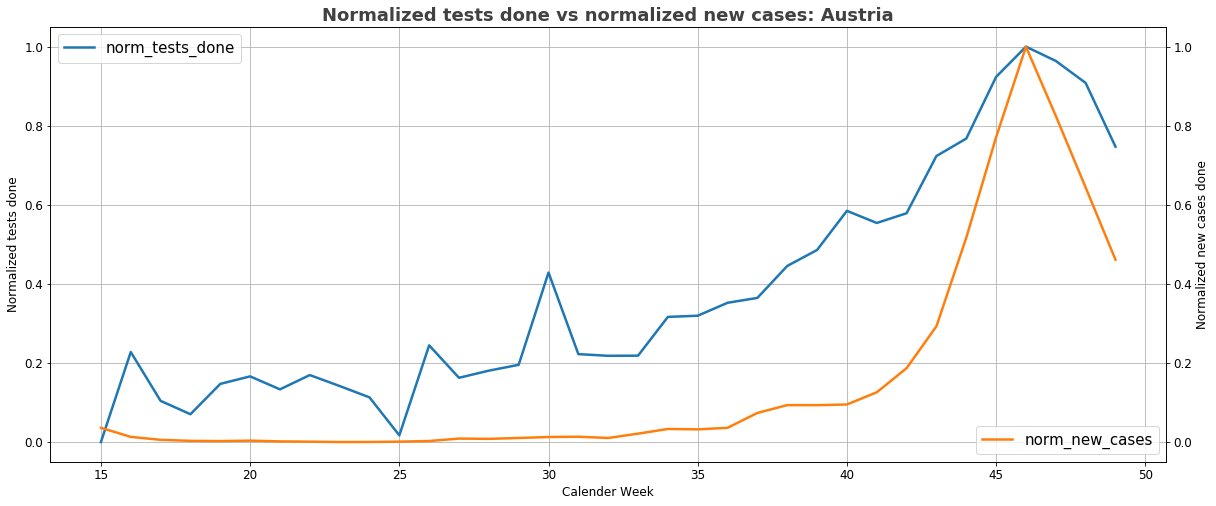

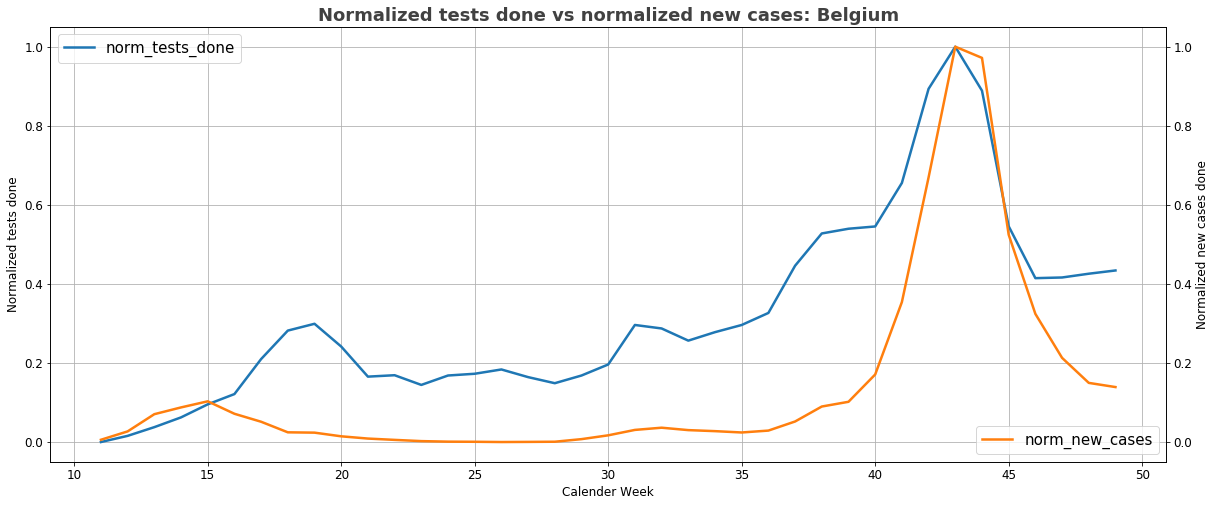

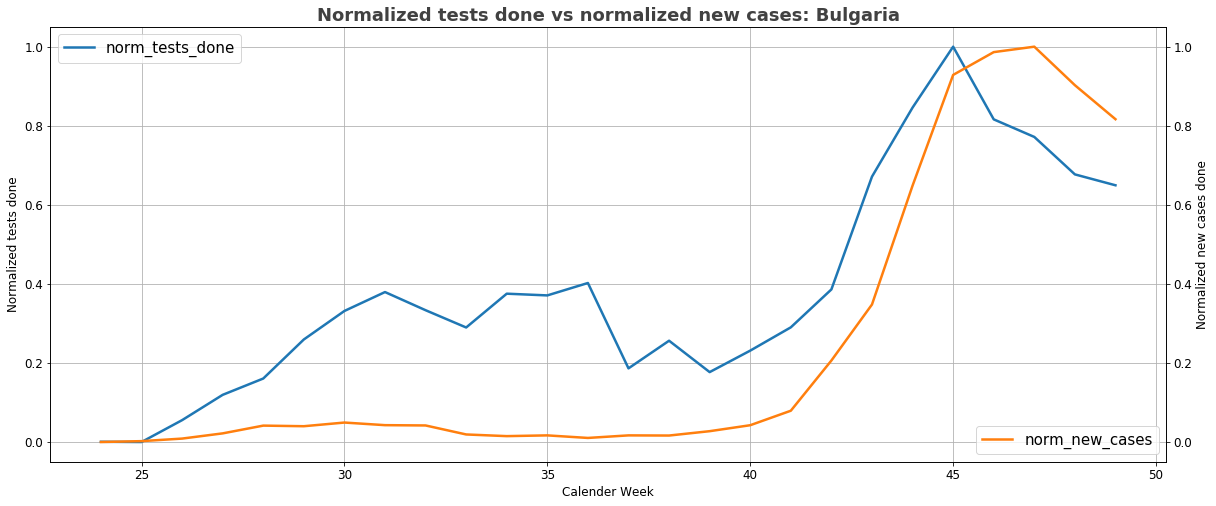

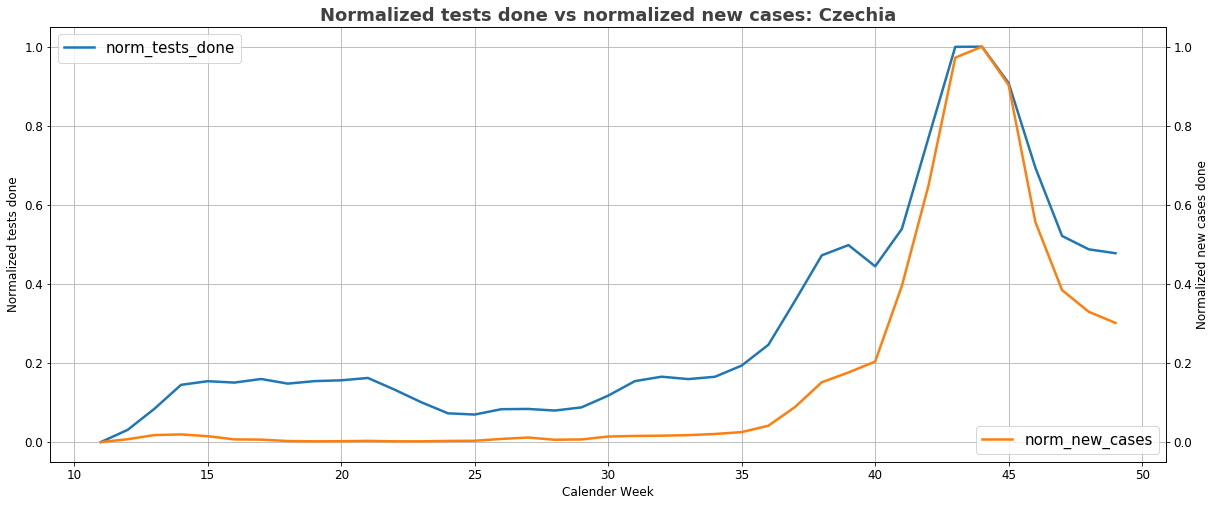

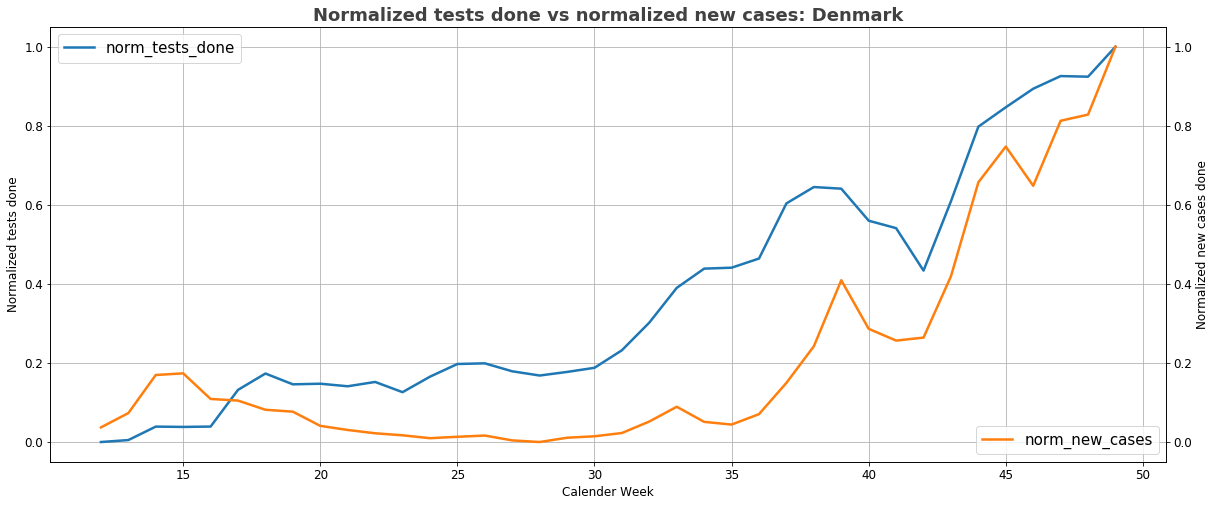

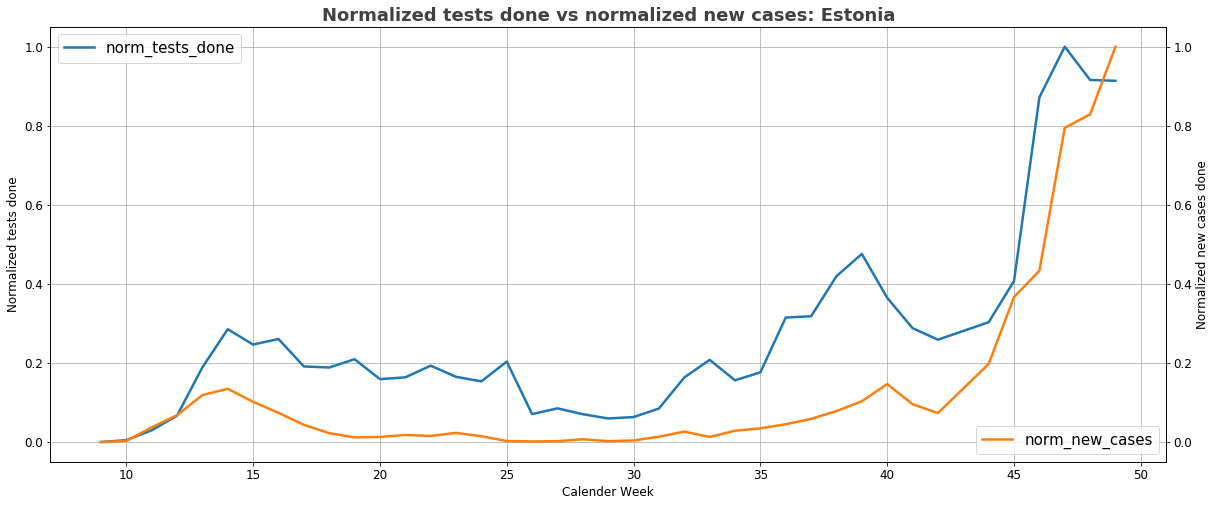

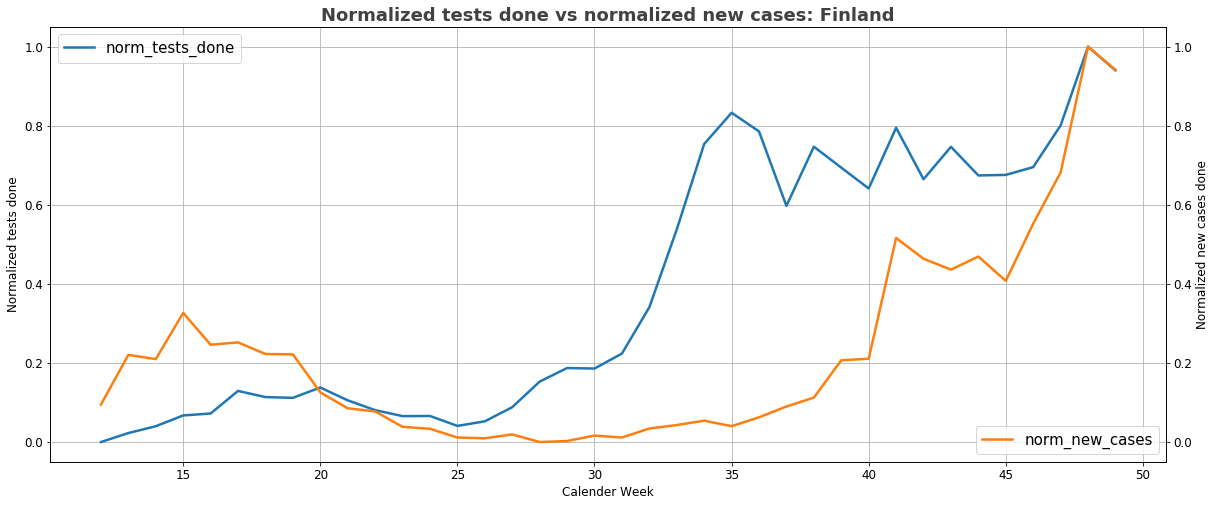

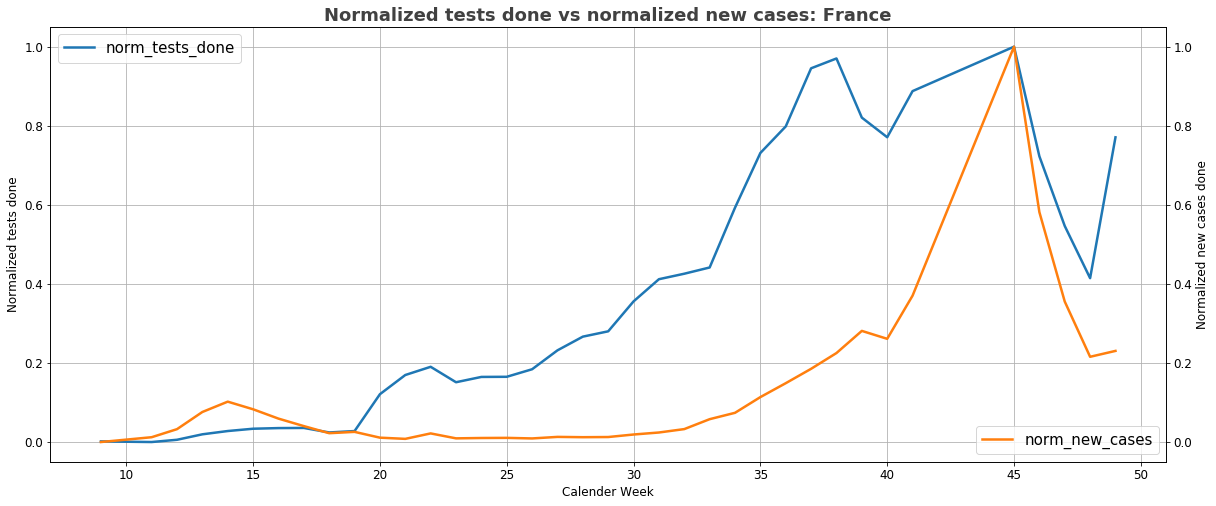

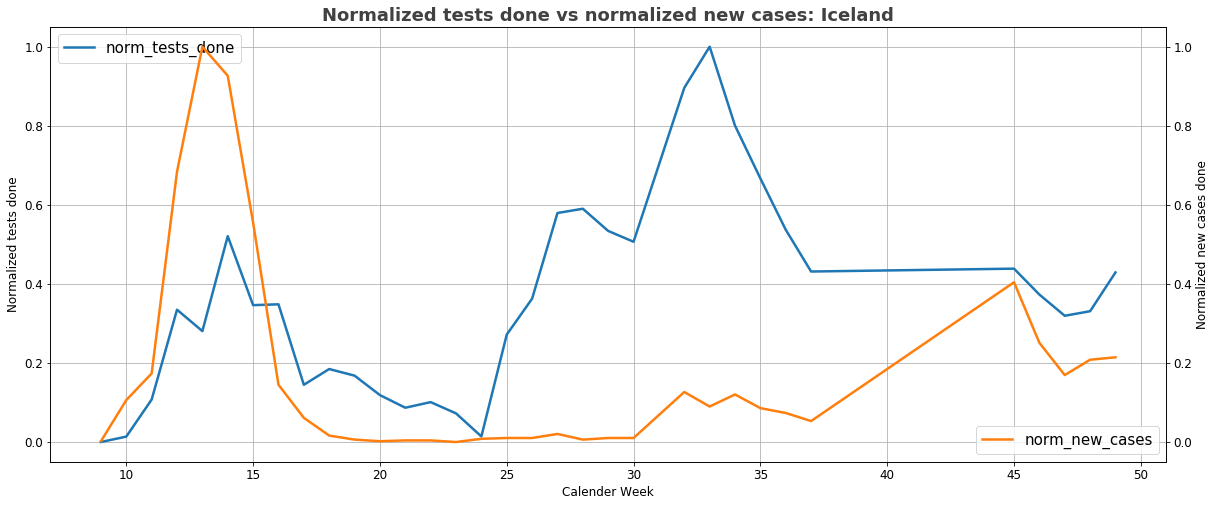

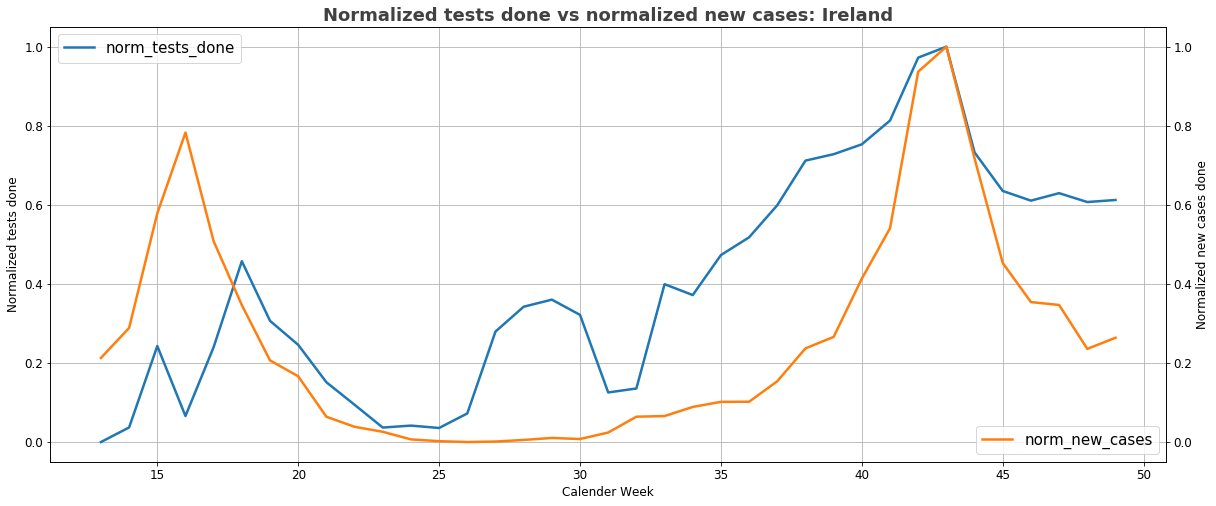

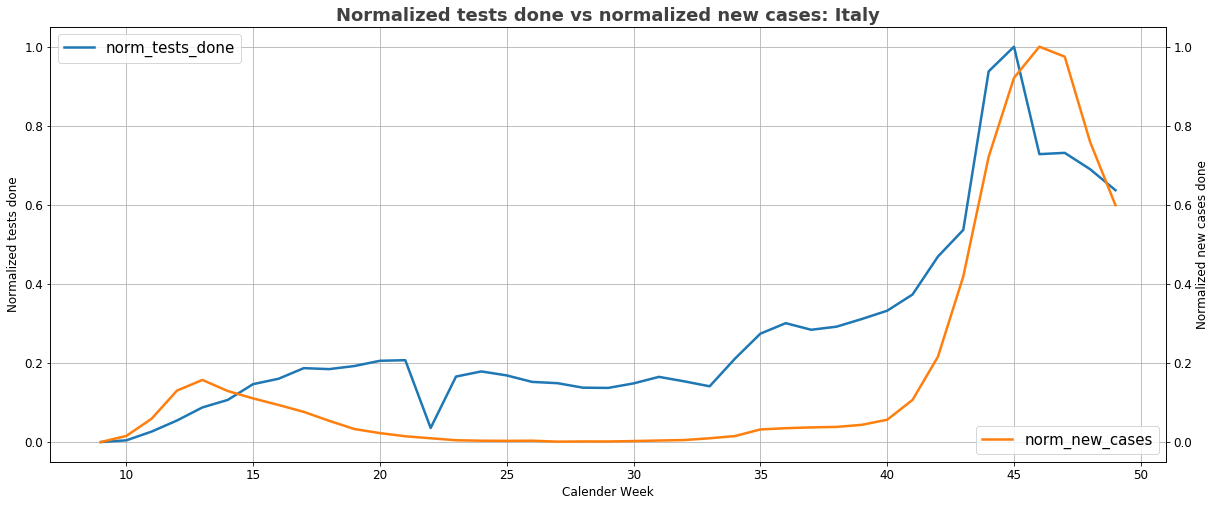

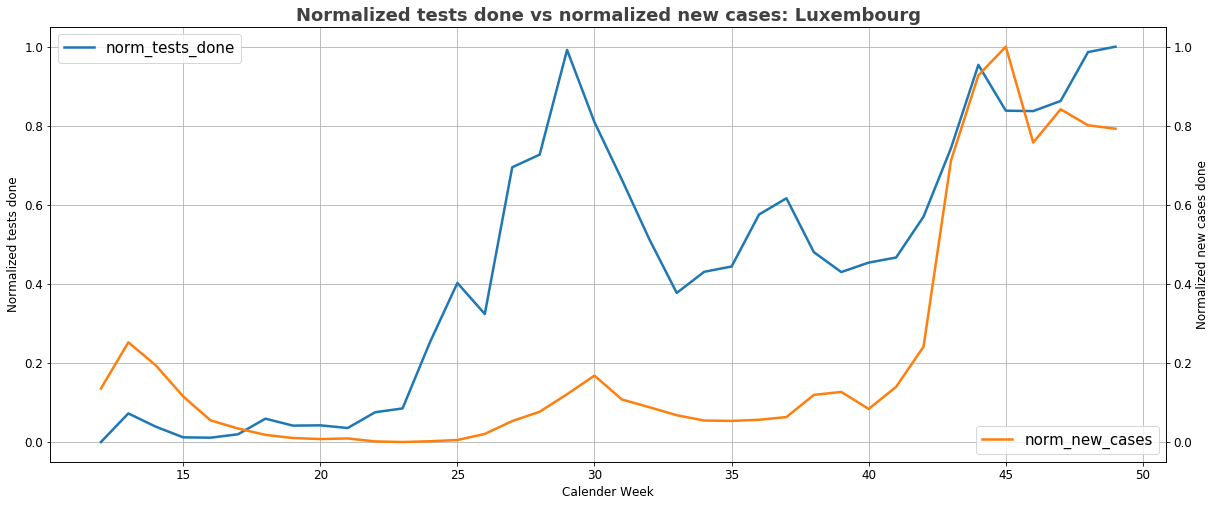

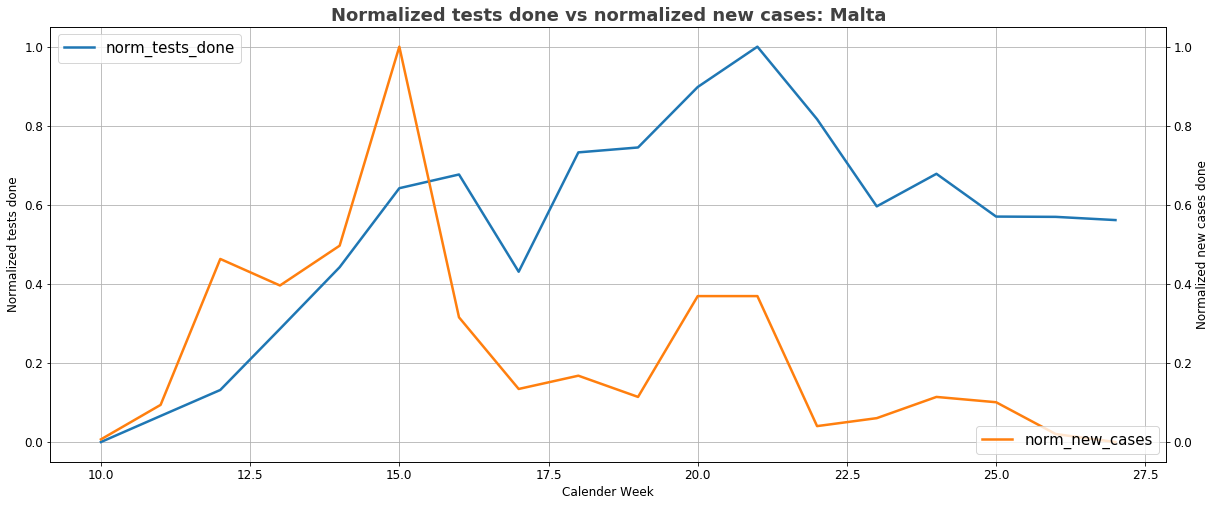

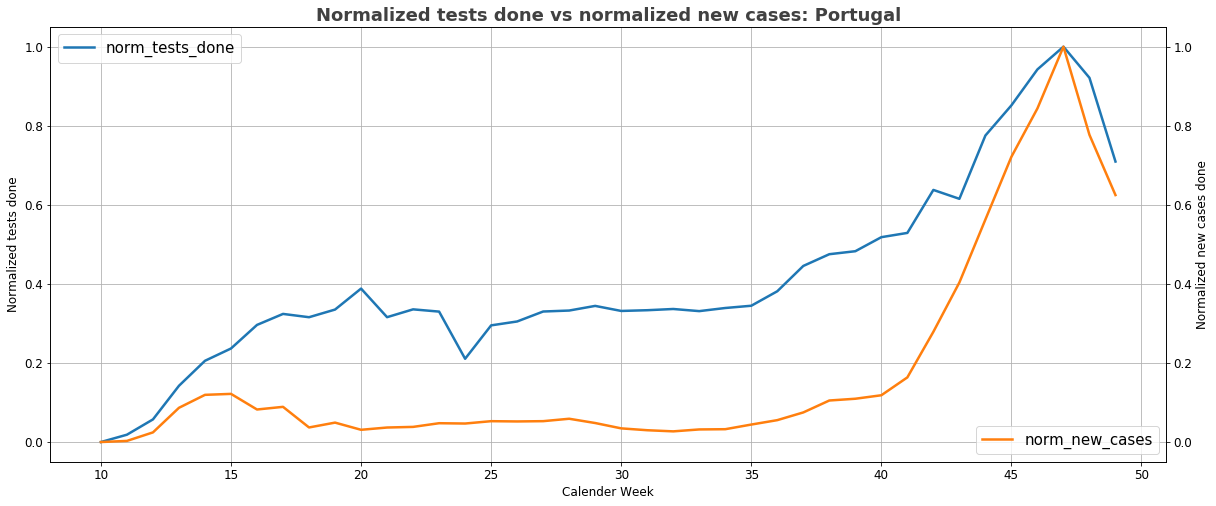

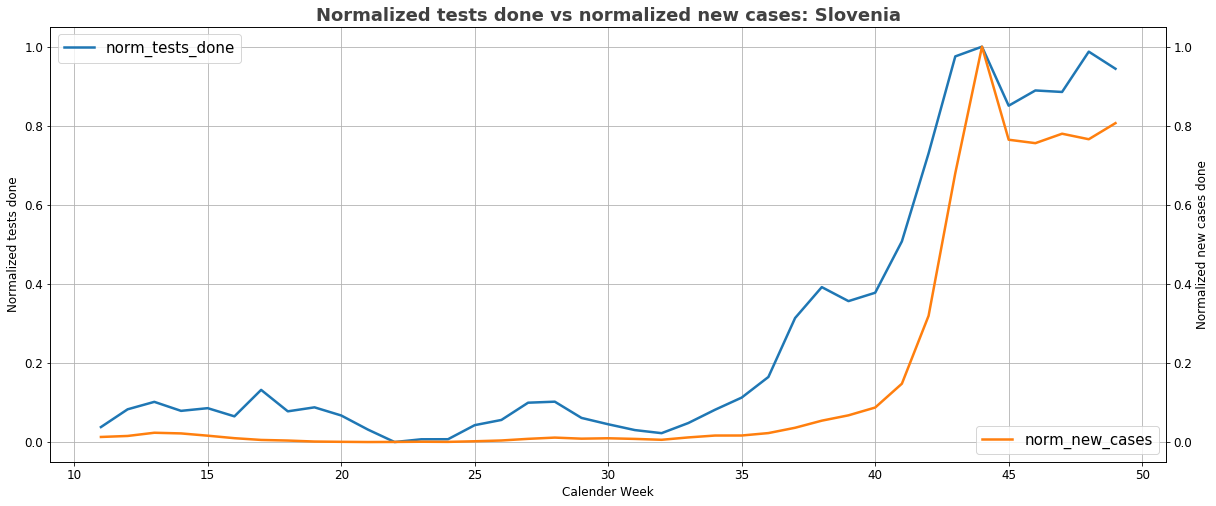

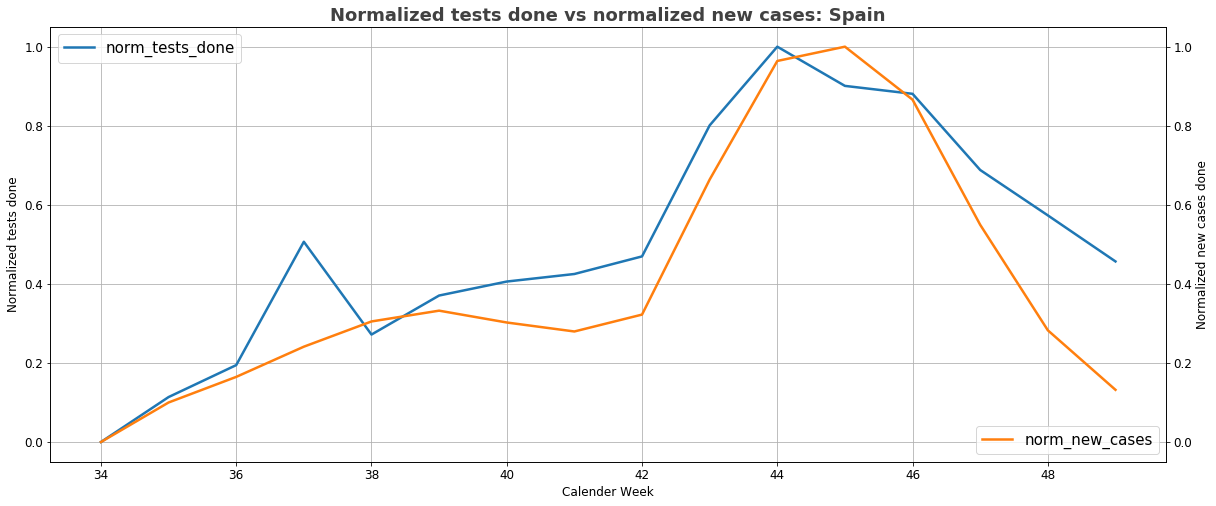

In [472]:
#Plotting tests done vs new cases:
for i,v in enumerate(df.country.unique()):
    fig, ax1 = plt.subplots(figsize=(20,8)) 
    ax1.set_title('Normalized tests done vs normalized new cases:'+ ' '+v,
    fontsize=18, 
    fontweight='semibold', color='#414141') 

    ax1.set_xlabel('report_week')
    ax1 = df[df.country == v].plot(x = 'cw', y = ['norm_tests_done'],linewidth = 2.5, ax = ax1)
    ax2 = df[df.country == v].plot(x = 'cw', y = ['norm_new_cases'],linewidth = 2.5, secondary_y = True, ax = ax1)
    ax1.grid(True)
    ax1.xaxis_labels = df[df.country == v].index
    ax2.xaxis_labels = df[df.country == v].index

    ax1.set_xlabel('Week')
    ax1.set_ylabel('Normalized tests done')
    ax1.set_xlabel("Calender Week", fontsize = 12)
    ax1.set_ylabel("Normalized tests done", fontsize = 12)
    ax2.set_ylabel('Normalized new cases done', fontsize = 12)

    ax1.tick_params(axis = 'both', which = 'major', labelsize = 12)
    ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)
    ax2.tick_params(axis = 'both', which = 'major', labelsize = 12)
    ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

    ax2.grid(False)
    ax1.grid(True)

    ax1.legend(loc = 2,fontsize = 15)
    ax2.legend(loc = 4,fontsize = 15)
    plt.show()

In [470]:
df.columns

Index(['country', 'cw', 'icu_occupancy', 'hosp_occupancy',
       'countriesAndTerritories', 'deaths', 'new_cases', 'tests_done',
       'population', 'positive_rate', 'norm_tests_done', 'norm_new_cases',
       'norm_hosp_occupancy', 'norm_icu_occupancy', 'norm_deaths'],
      dtype='object')

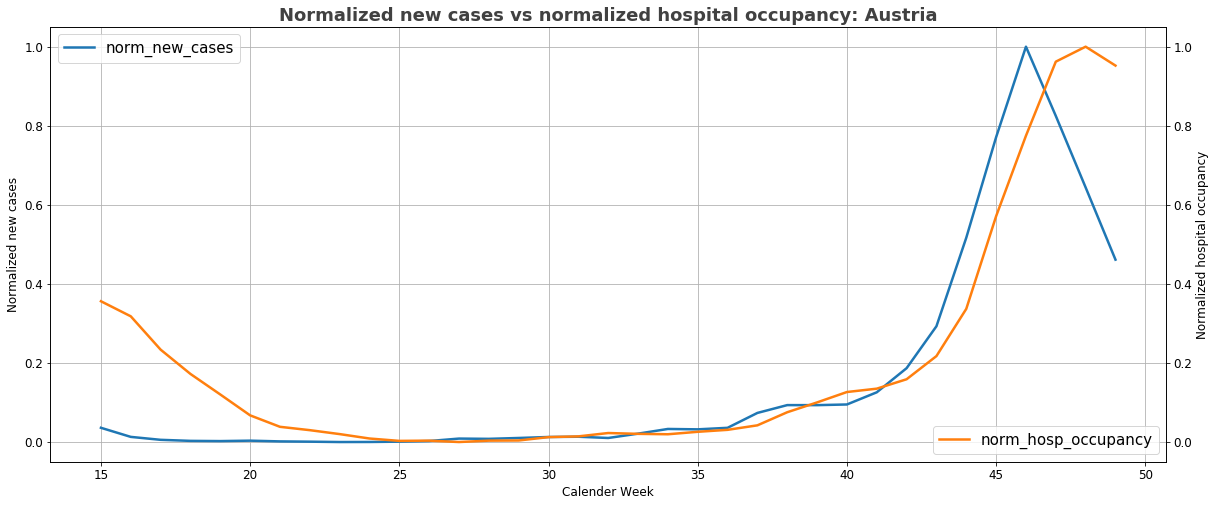

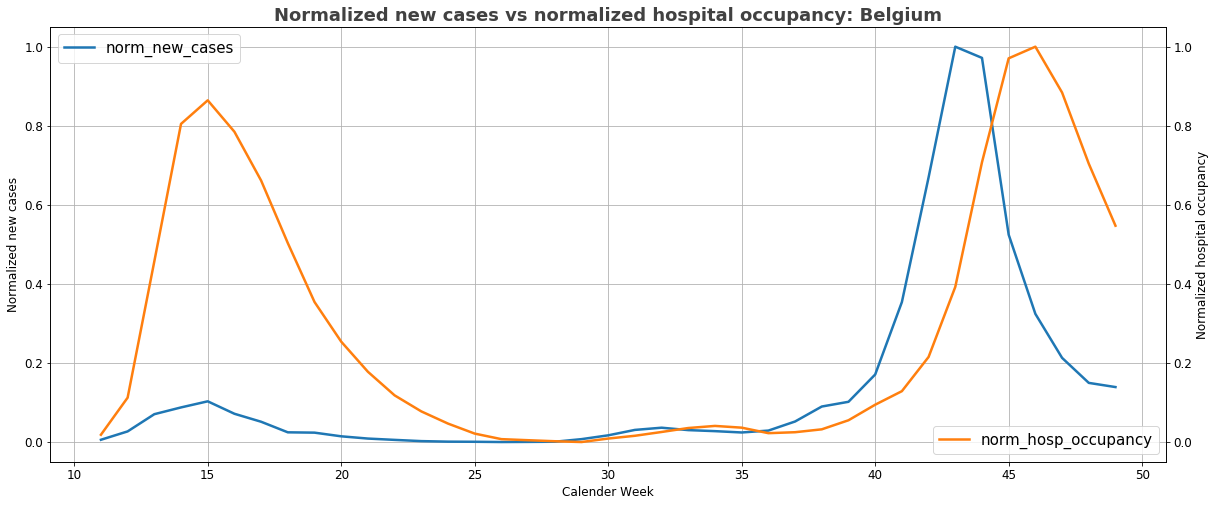

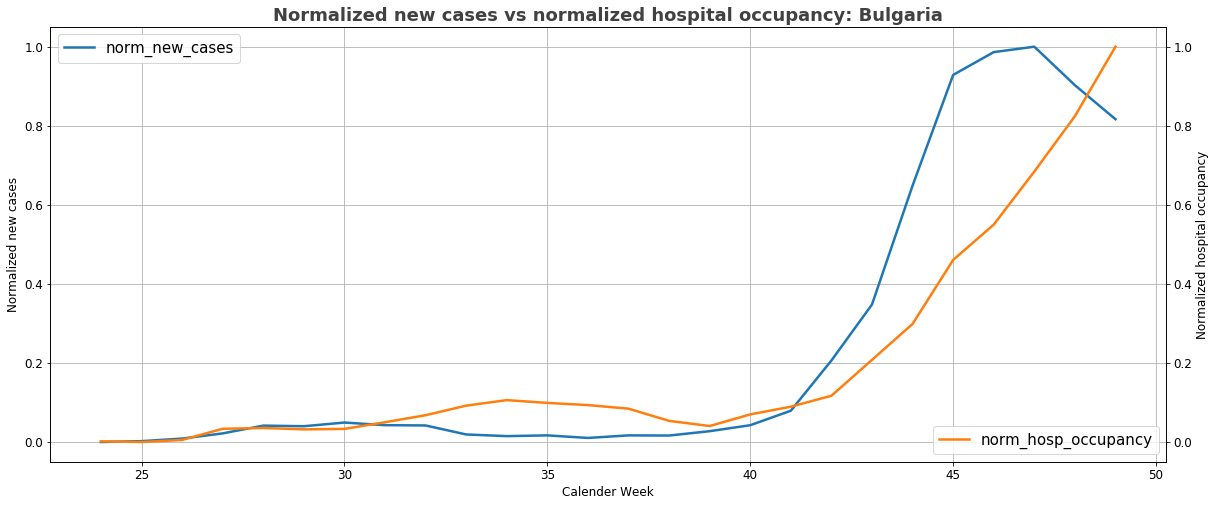

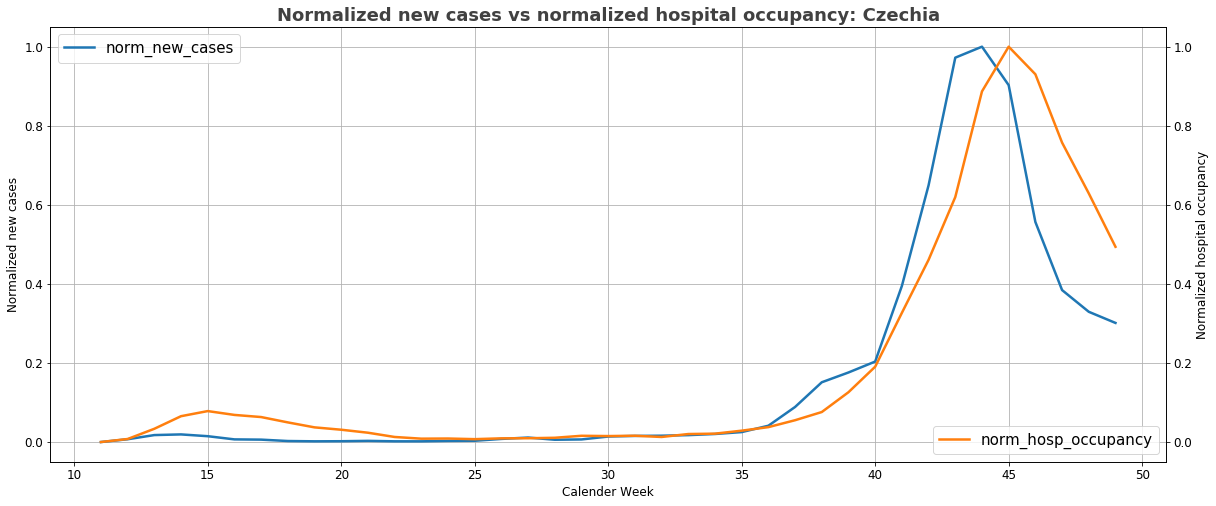

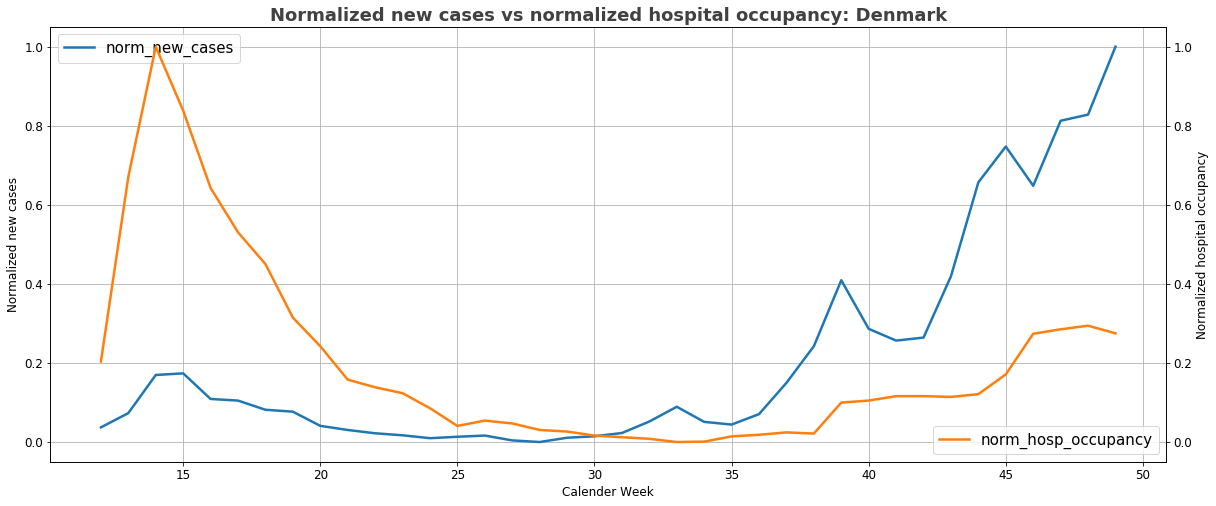

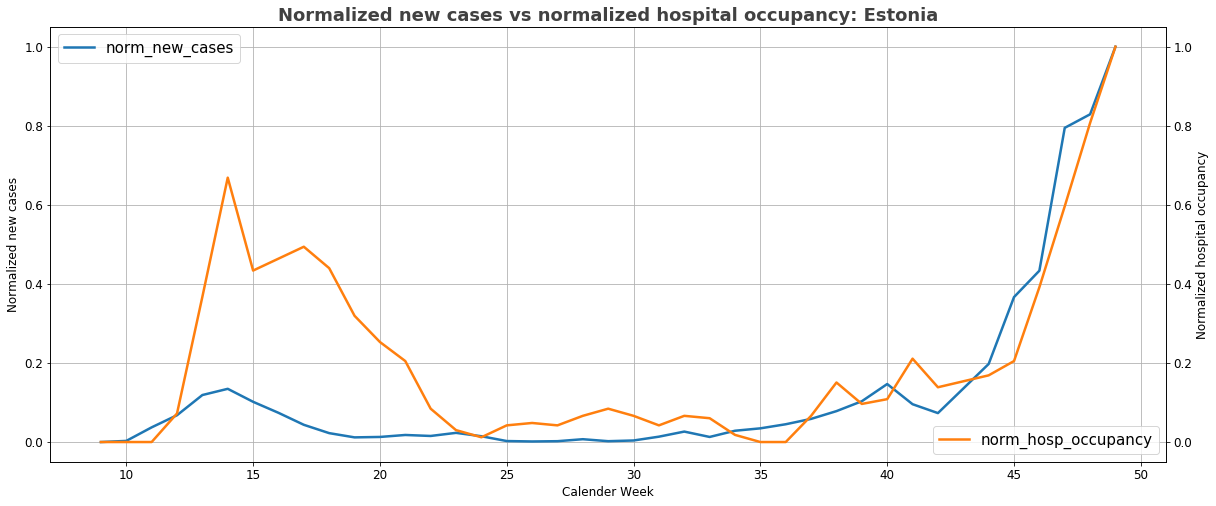

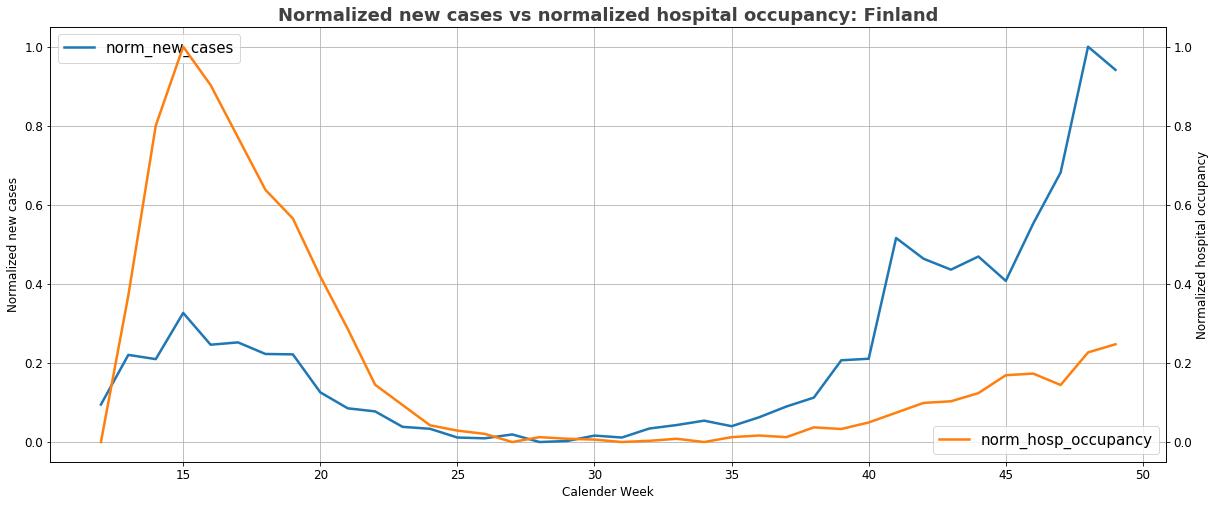

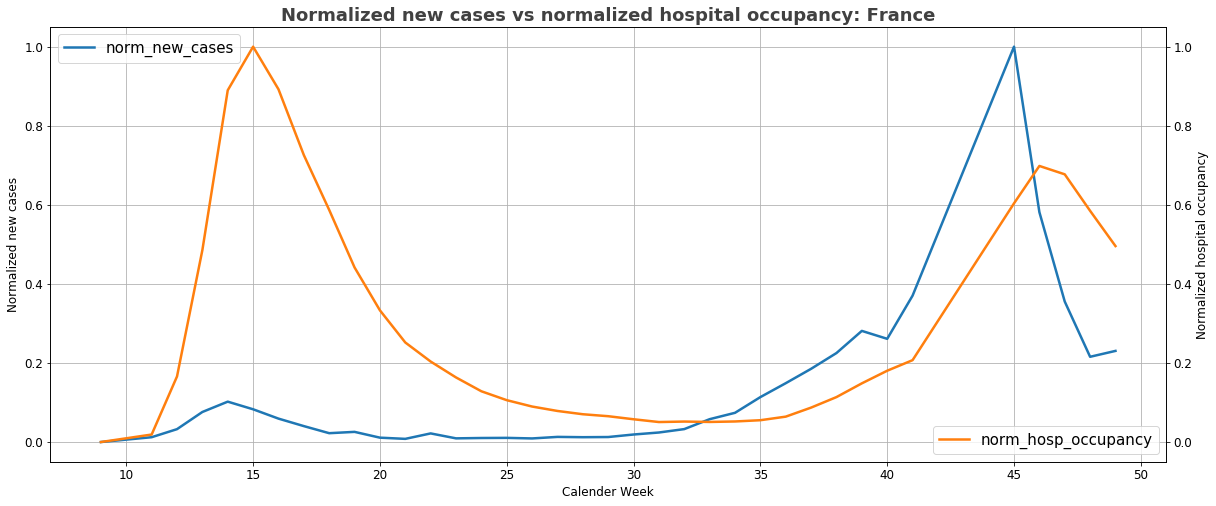

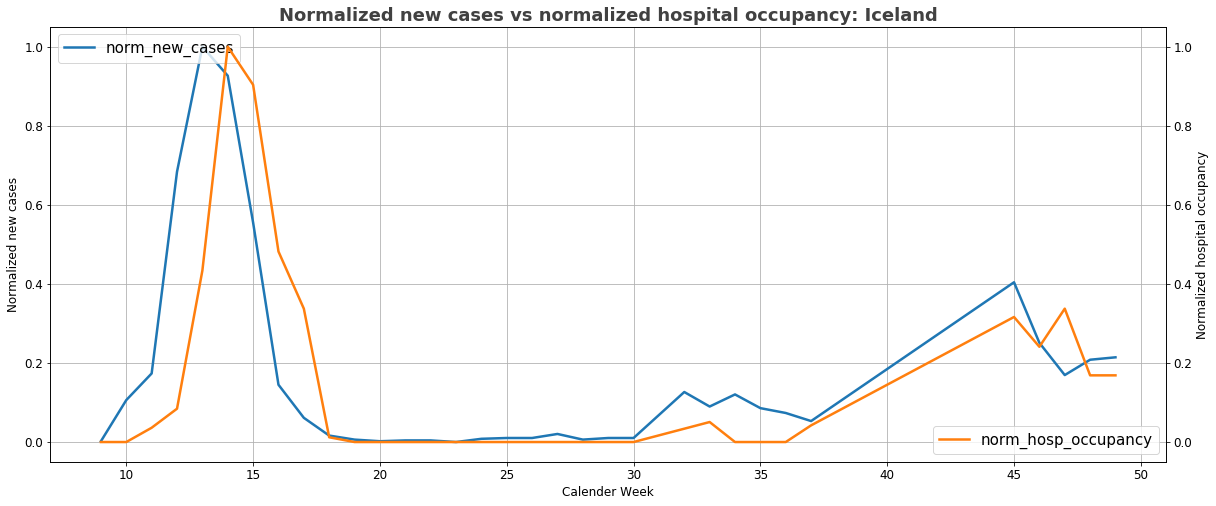

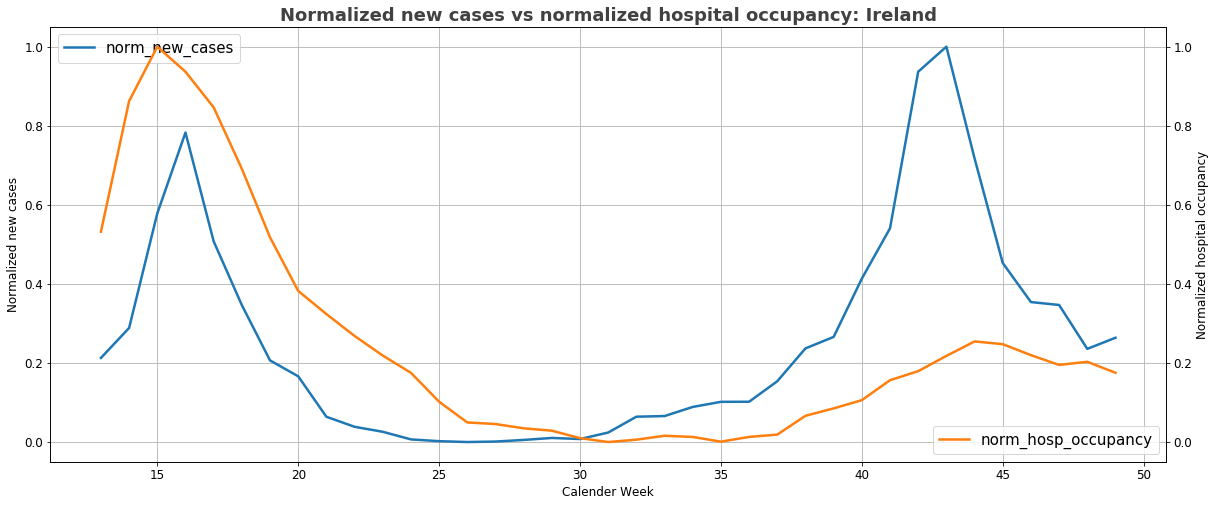

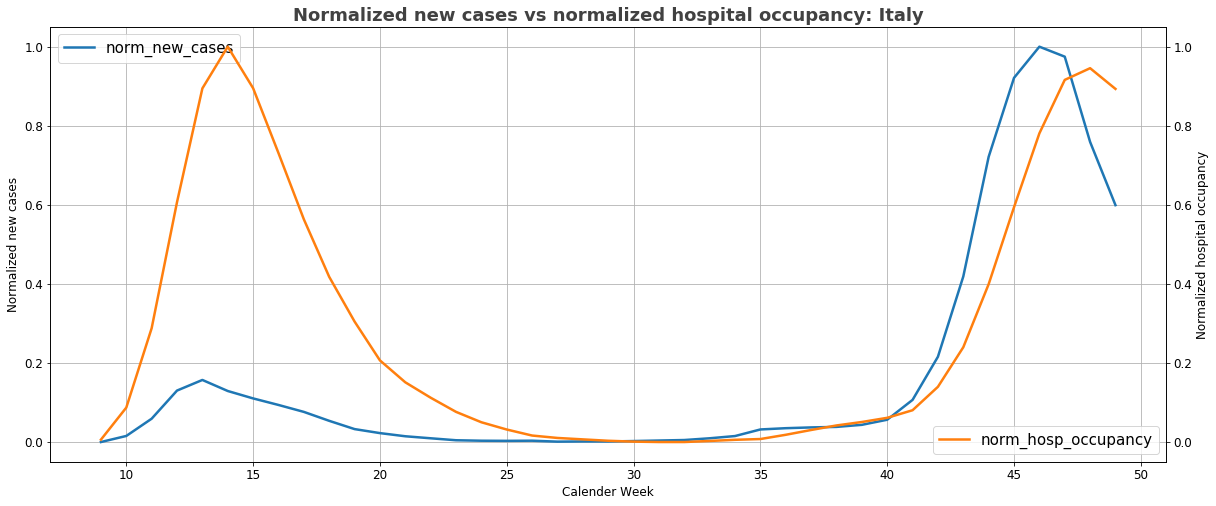

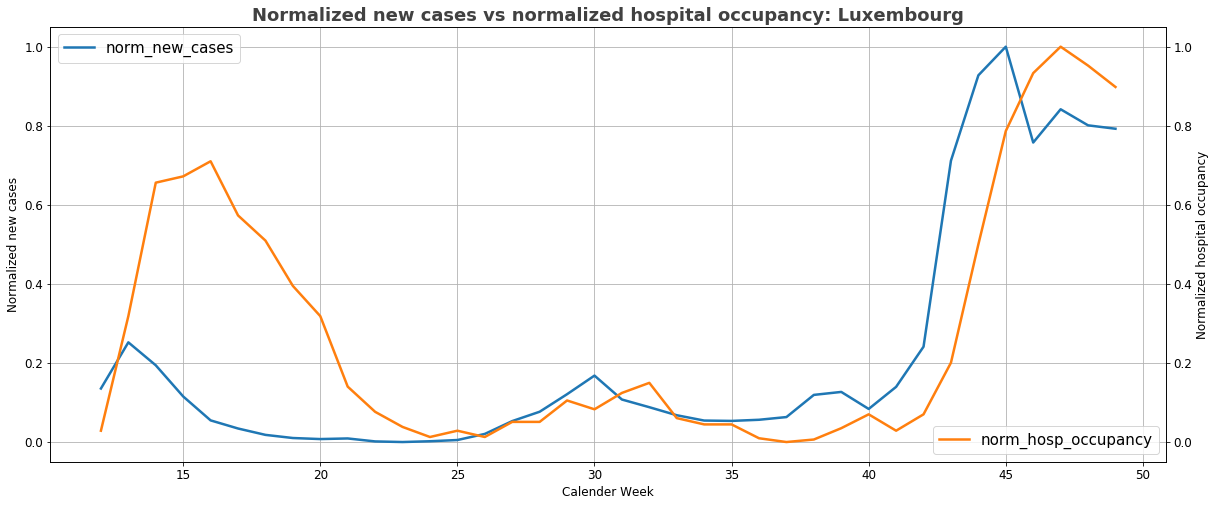

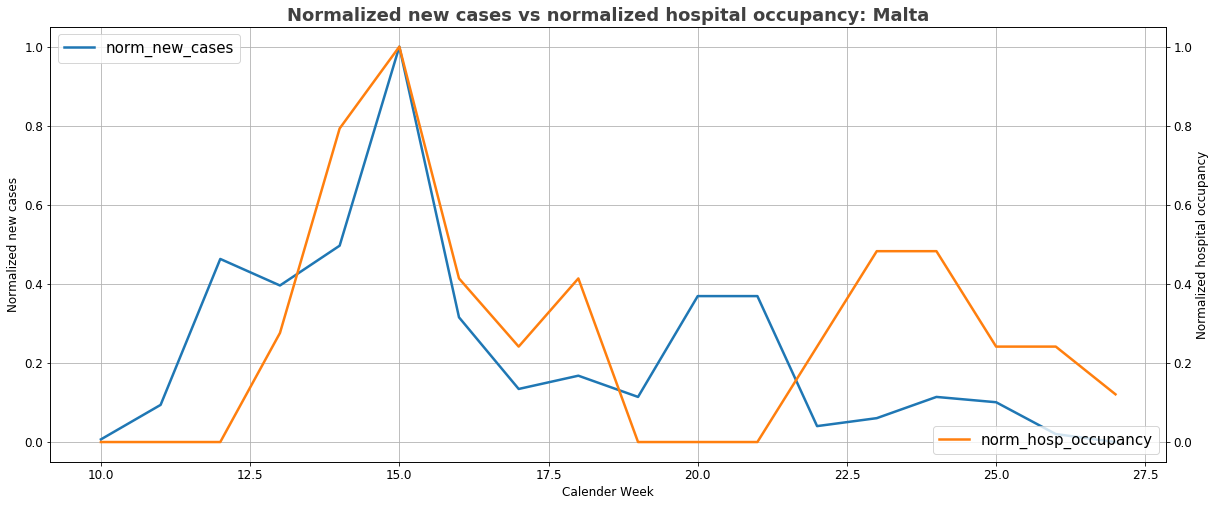

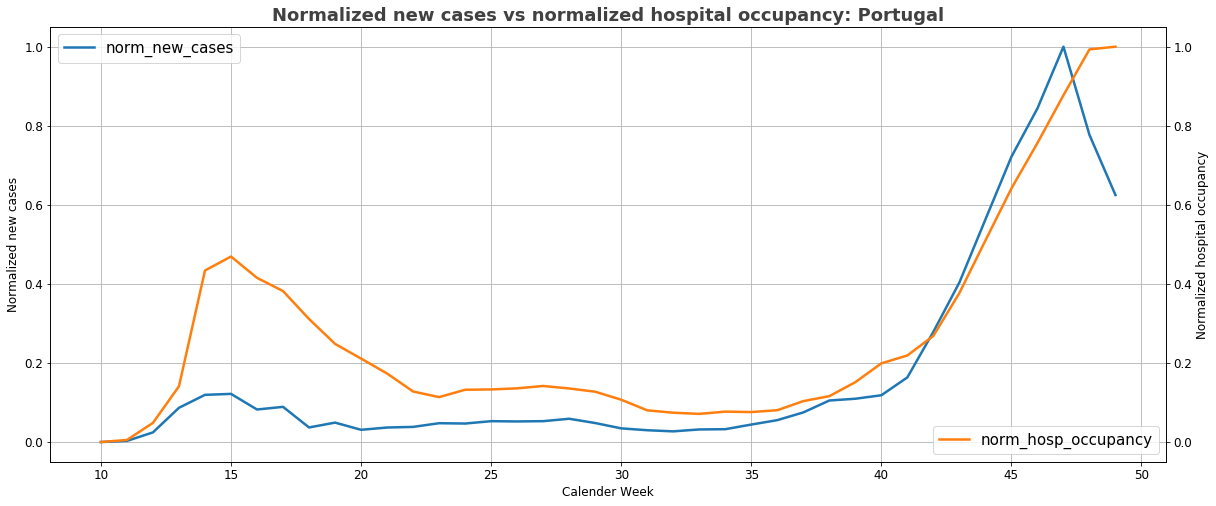

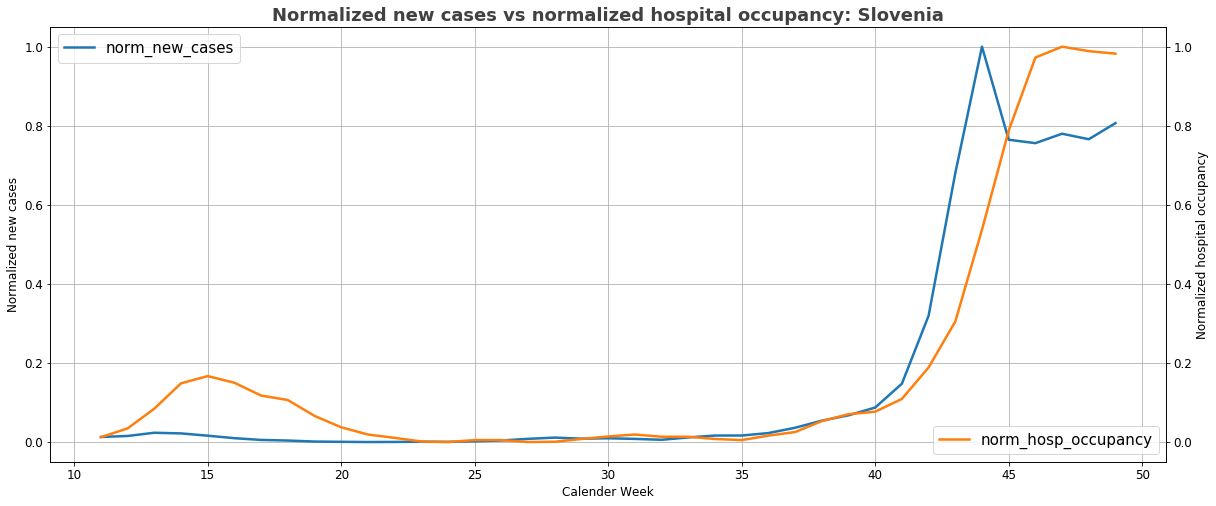

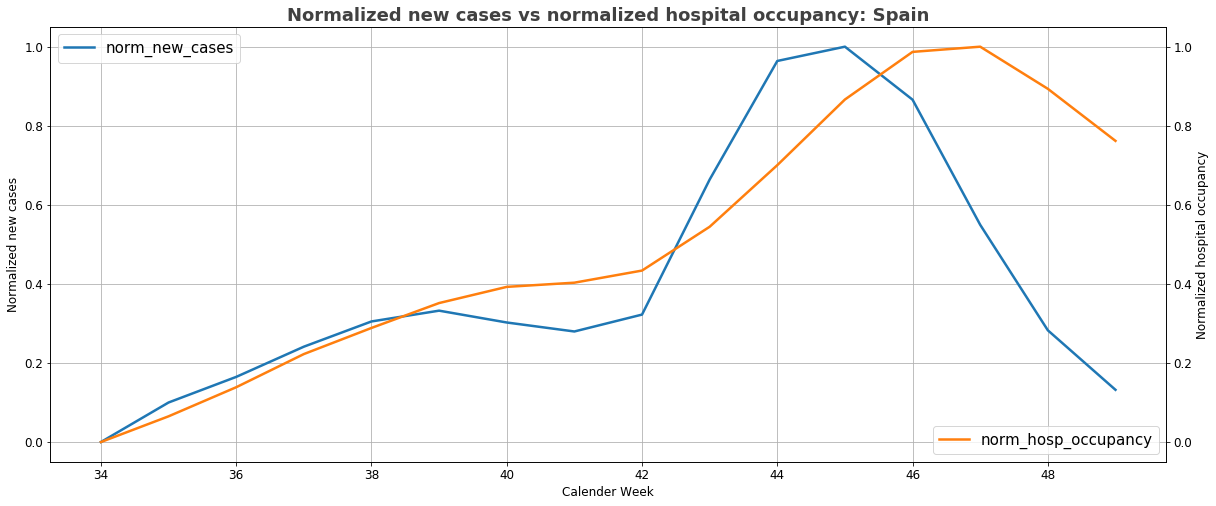

In [473]:
#Plotting new cases vs norm_hosp_occupancy:
for i,v in enumerate(df.country.unique()):
    fig, ax1 = plt.subplots(figsize=(20,8)) 
    ax1.set_title('Normalized new cases vs normalized hospital occupancy:'+ ' '+v,
    fontsize=18, 
    fontweight='semibold', color='#414141') 

    ax1.set_xlabel('report_week')
    ax1 = df[df.country == v].plot(x = 'cw', y = ['norm_new_cases'],linewidth = 2.5, ax = ax1)
    ax2 = df[df.country == v].plot(x = 'cw', y = ['norm_hosp_occupancy'],linewidth = 2.5, secondary_y = True, ax = ax1)
    ax1.grid(True)
    ax1.xaxis_labels = df[df.country == v].index
    ax2.xaxis_labels = df[df.country == v].index

    ax1.set_xlabel('Week')
    ax1.set_ylabel('Normalized new cases')
    ax1.set_xlabel("Calender Week", fontsize = 12)
    ax1.set_ylabel("Normalized new cases", fontsize = 12)
    ax2.set_ylabel('Normalized hospital occupancy', fontsize = 12)

    ax1.tick_params(axis = 'both', which = 'major', labelsize = 12)
    ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)
    ax2.tick_params(axis = 'both', which = 'major', labelsize = 12)
    ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

    ax2.grid(False)
    ax1.grid(True)

    ax1.legend(loc = 2,fontsize = 15)
    ax2.legend(loc = 4,fontsize = 15)
    plt.show()

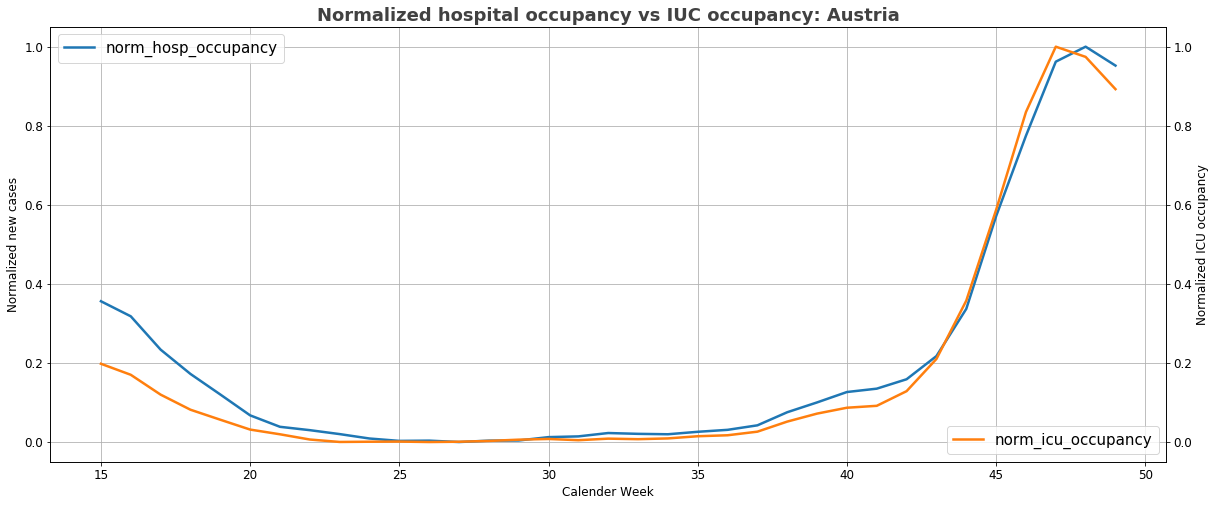

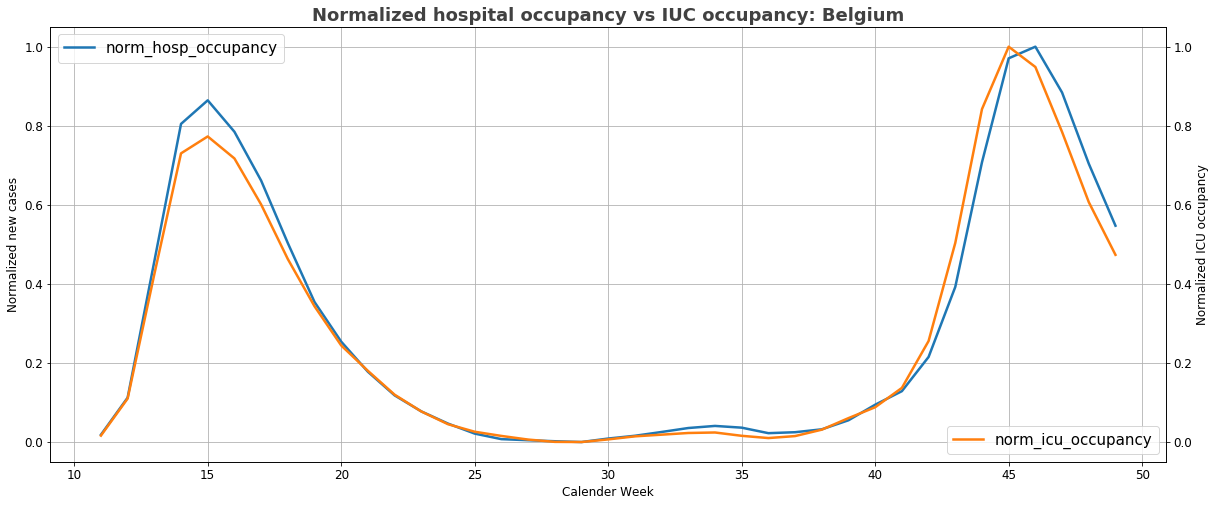

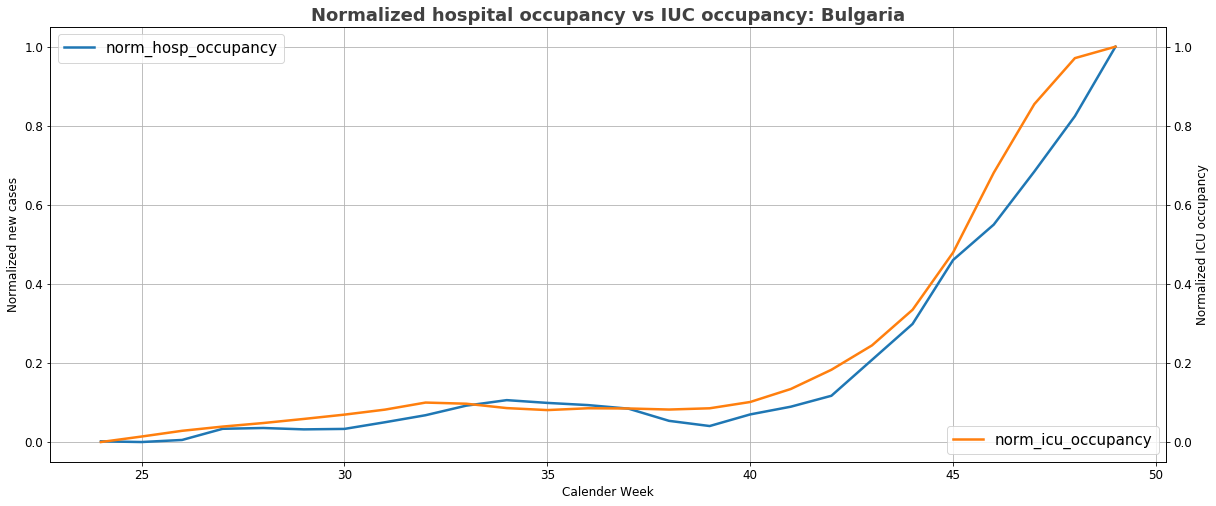

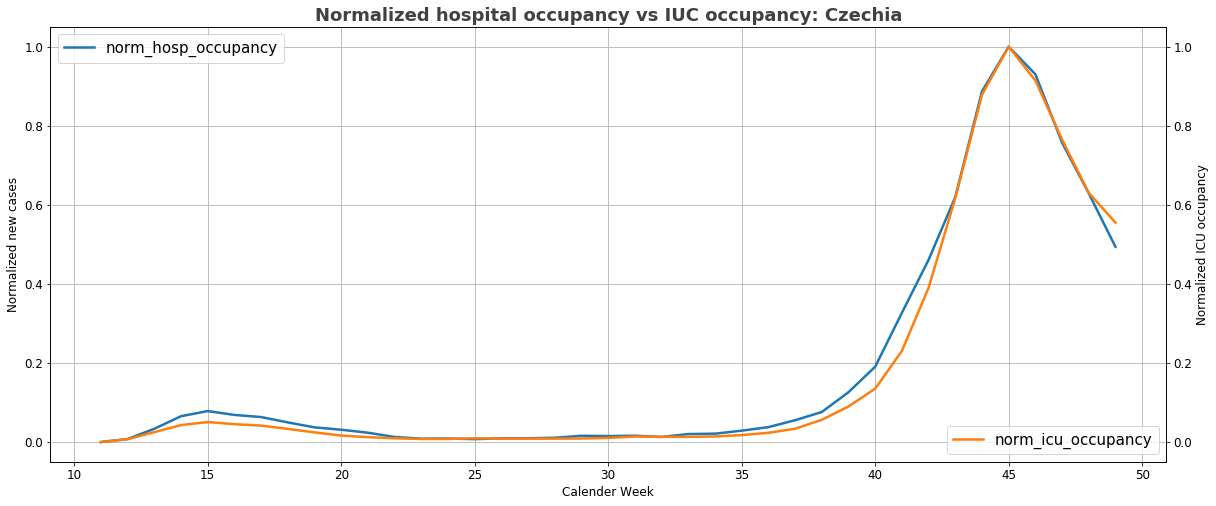

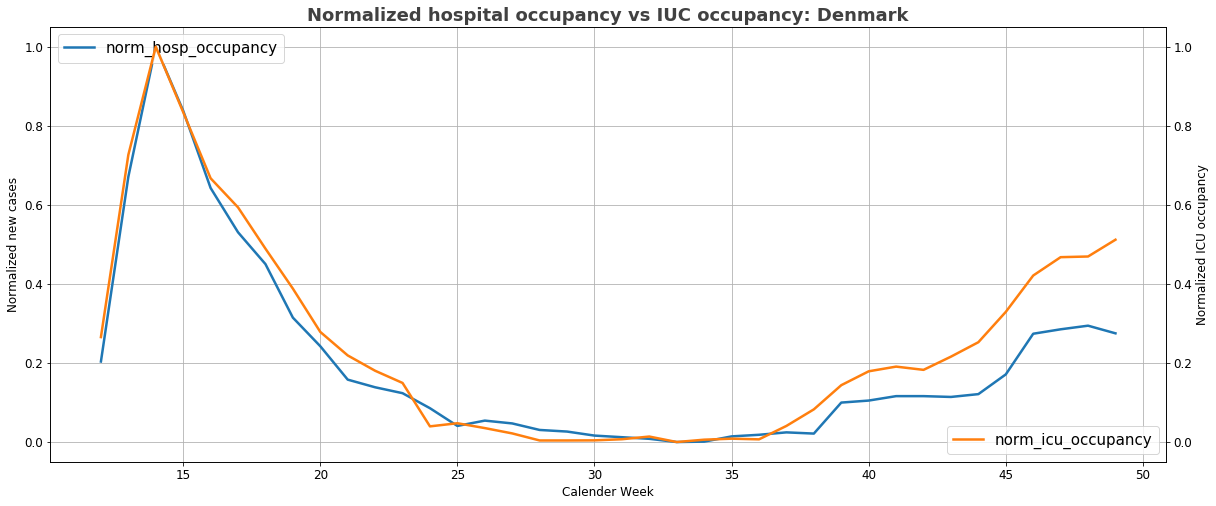

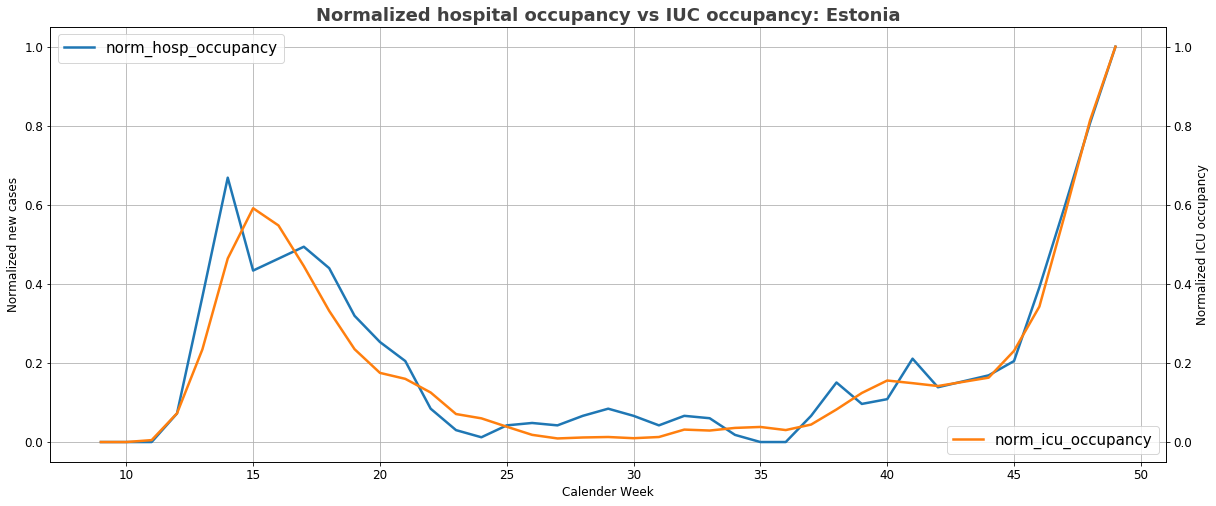

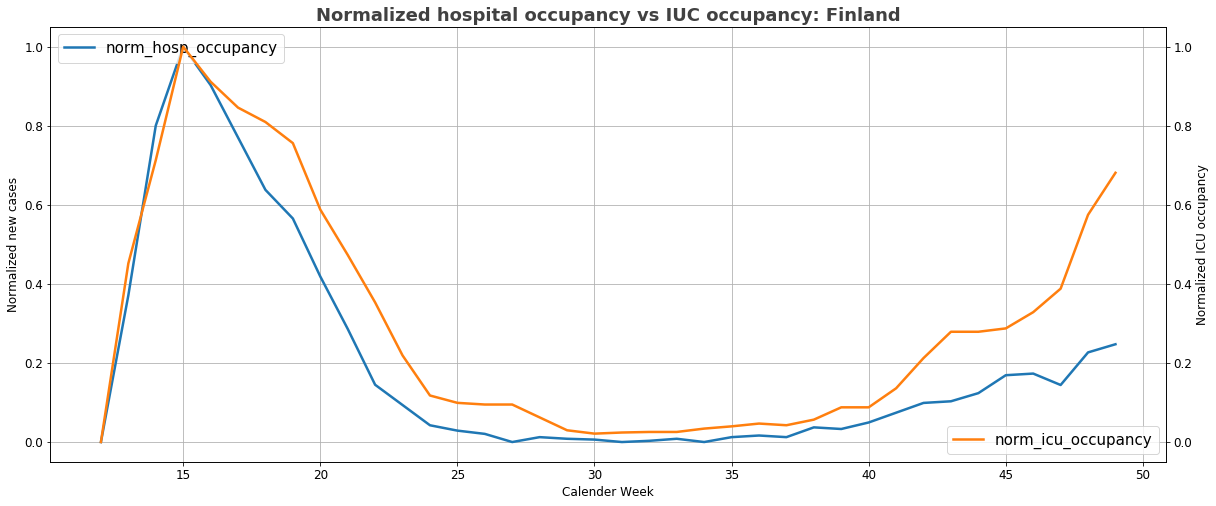

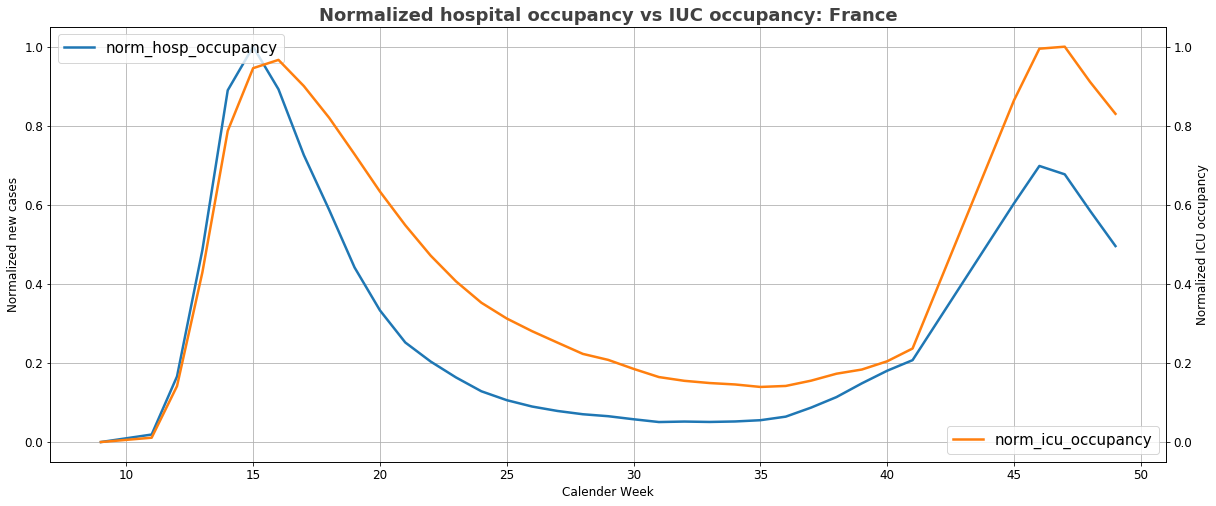

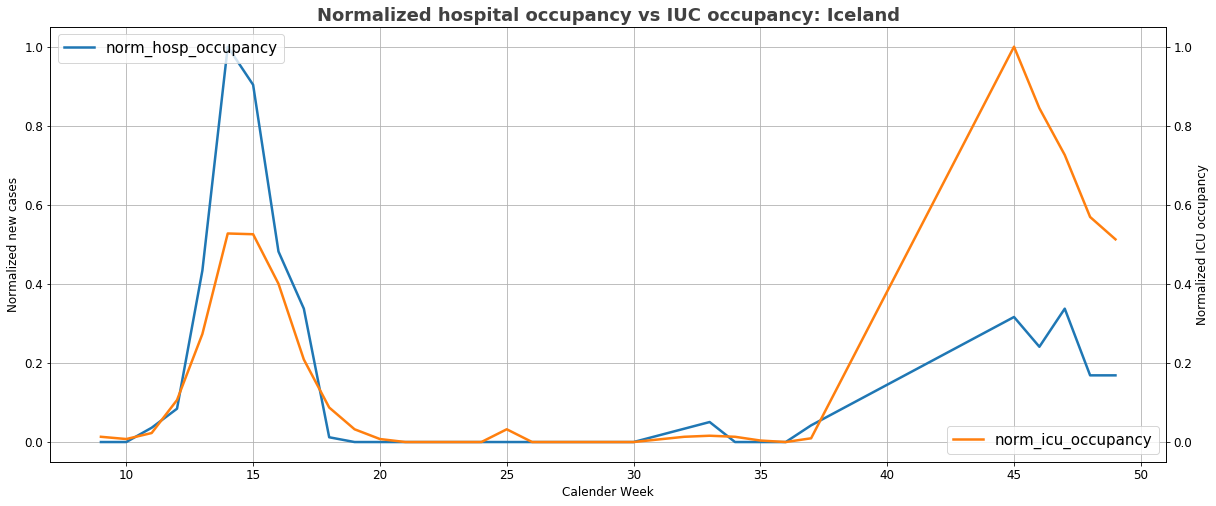

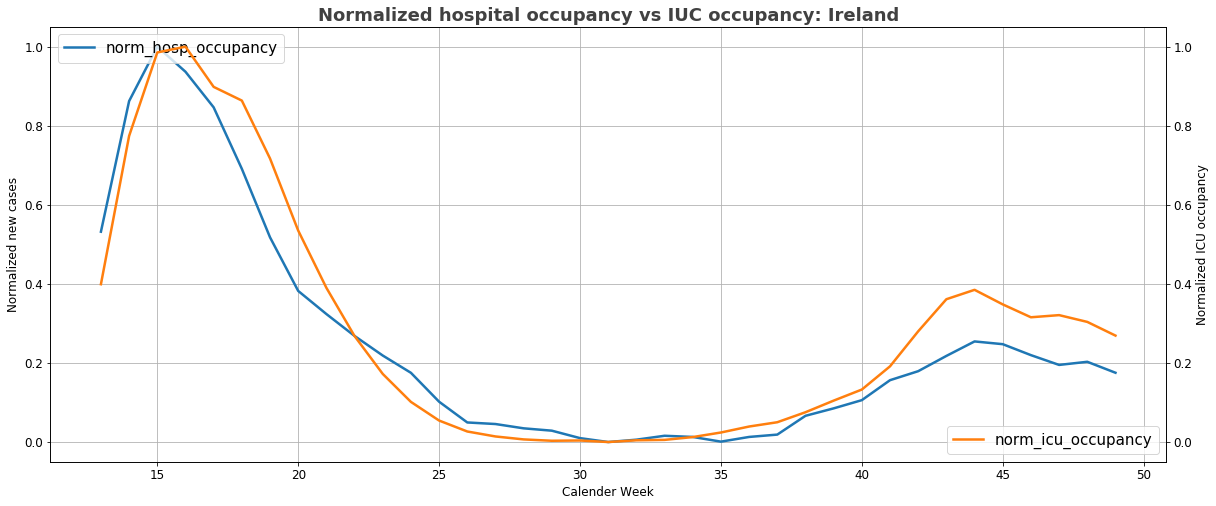

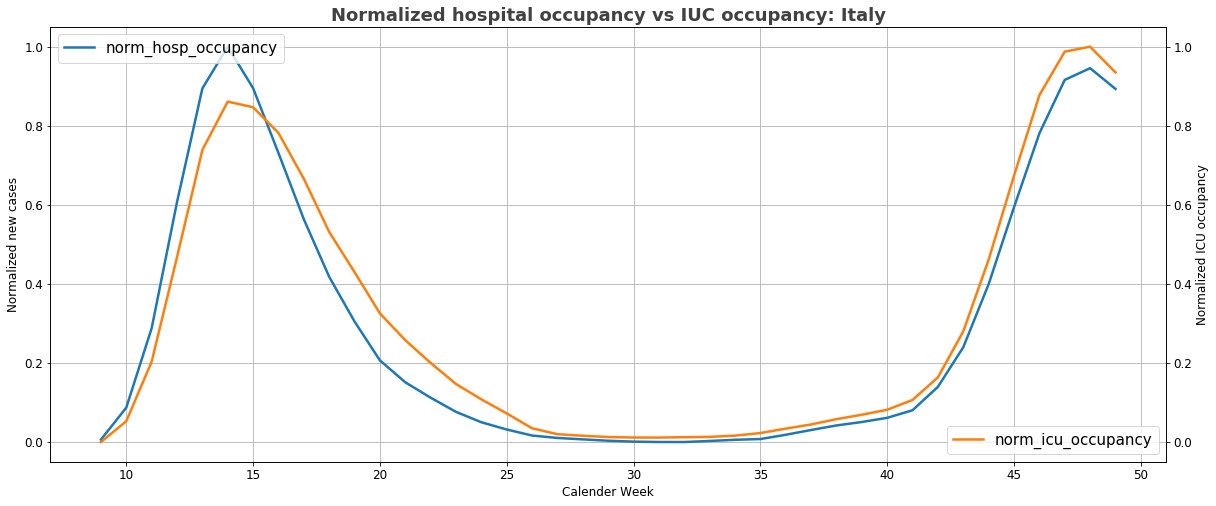

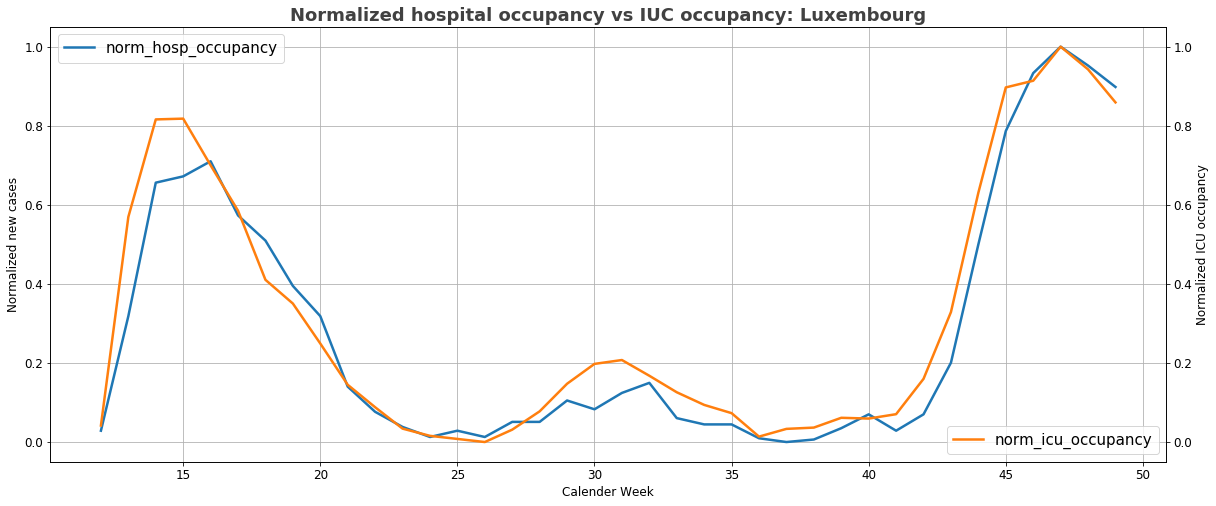

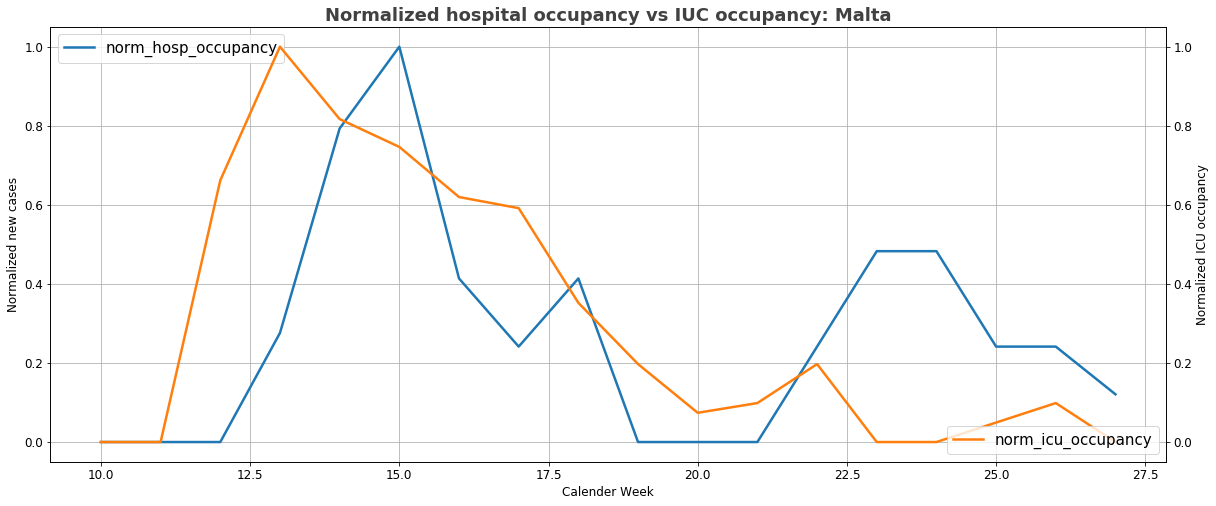

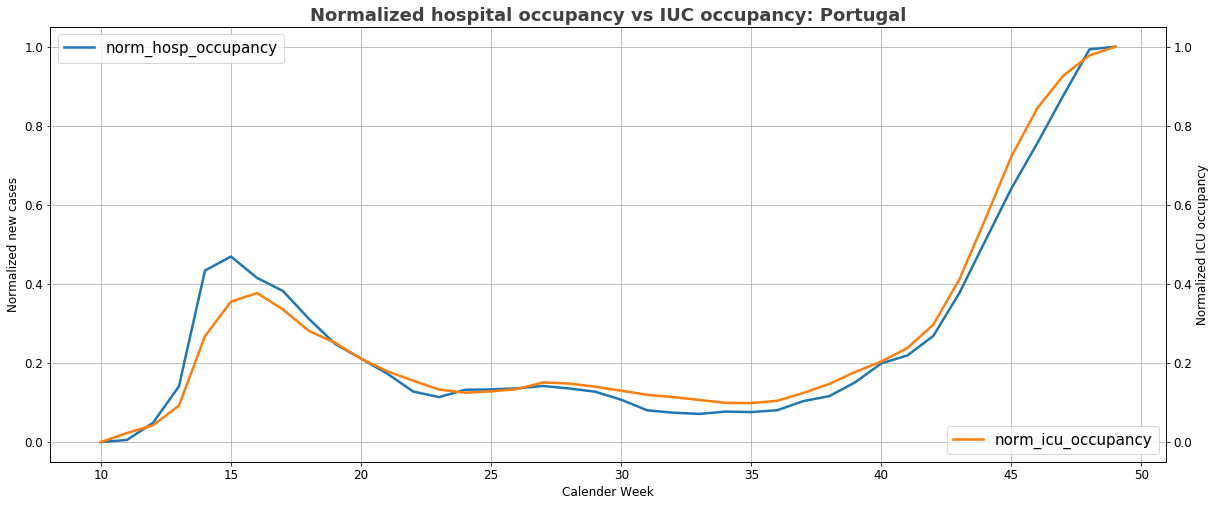

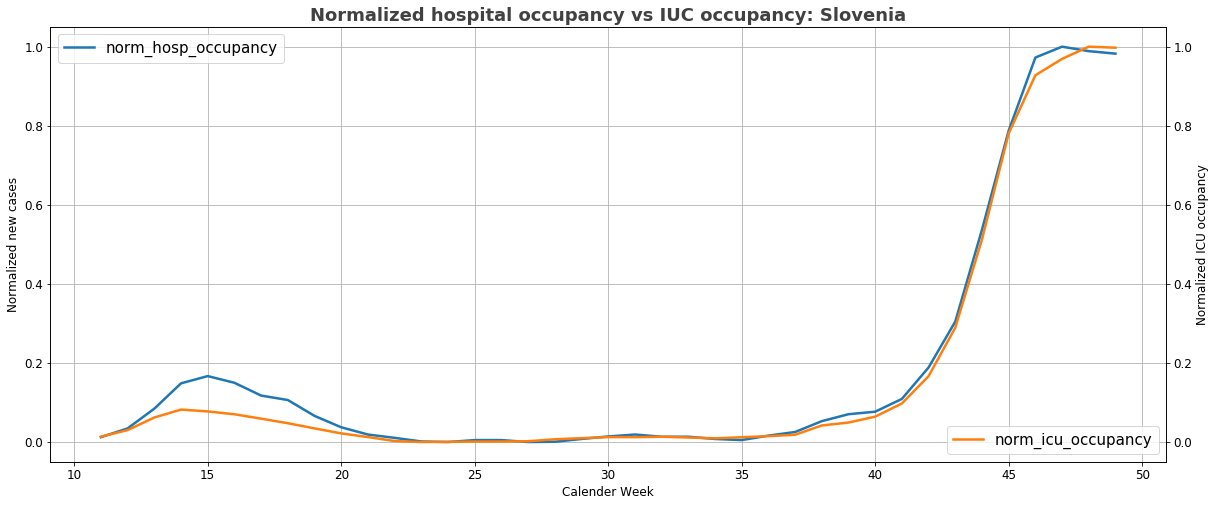

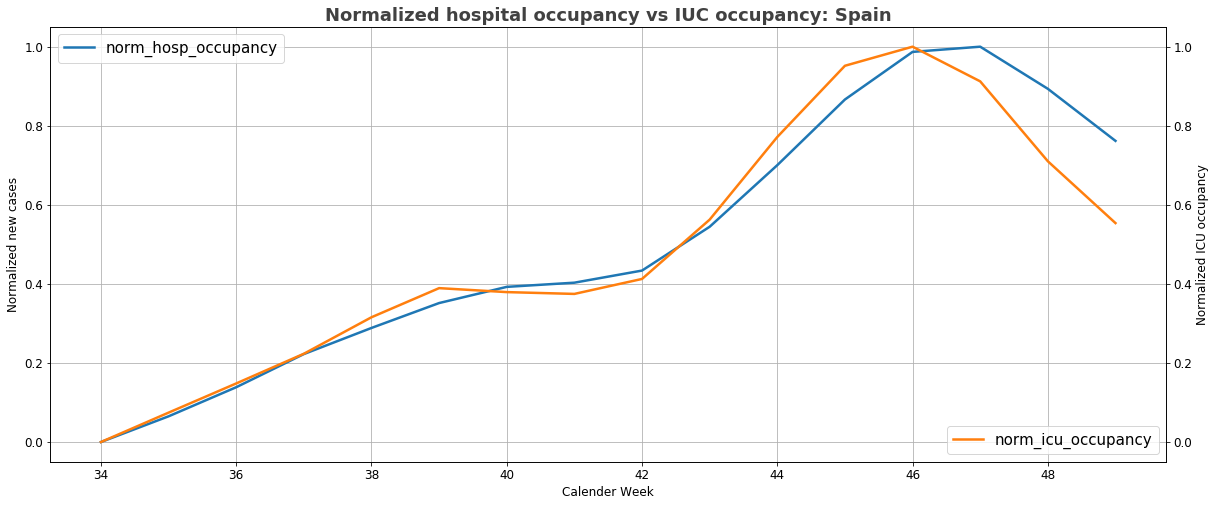

In [476]:
#Plotting norm_hosp_occupancy vs ICU occupancy:
for i,v in enumerate(df.country.unique()):
    fig, ax1 = plt.subplots(figsize=(20,8)) 
    ax1.set_title('Normalized hospital occupancy vs IUC occupancy:'+ ' '+v,
    fontsize=18, 
    fontweight='semibold', color='#414141') 

    ax1.set_xlabel('report_week')
    ax1 = df[df.country == v].plot(x = 'cw', y = ['norm_hosp_occupancy'],linewidth = 2.5, ax = ax1)
    ax2 = df[df.country == v].plot(x = 'cw', y = ['norm_icu_occupancy'],linewidth = 2.5, secondary_y = True, ax = ax1)
    ax1.grid(True)
    ax1.xaxis_labels = df[df.country == v].index
    ax2.xaxis_labels = df[df.country == v].index

    ax1.set_xlabel('Week')
    ax1.set_ylabel('Normalized hospital occupancy')
    ax1.set_xlabel("Calender Week", fontsize = 12)
    ax1.set_ylabel("Normalized new cases", fontsize = 12)
    ax2.set_ylabel('Normalized ICU occupancy', fontsize = 12)

    ax1.tick_params(axis = 'both', which = 'major', labelsize = 12)
    ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)
    ax2.tick_params(axis = 'both', which = 'major', labelsize = 12)
    ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

    ax2.grid(False)
    ax1.grid(True)

    ax1.legend(loc = 2,fontsize = 15)
    ax2.legend(loc = 4,fontsize = 15)
    plt.show()

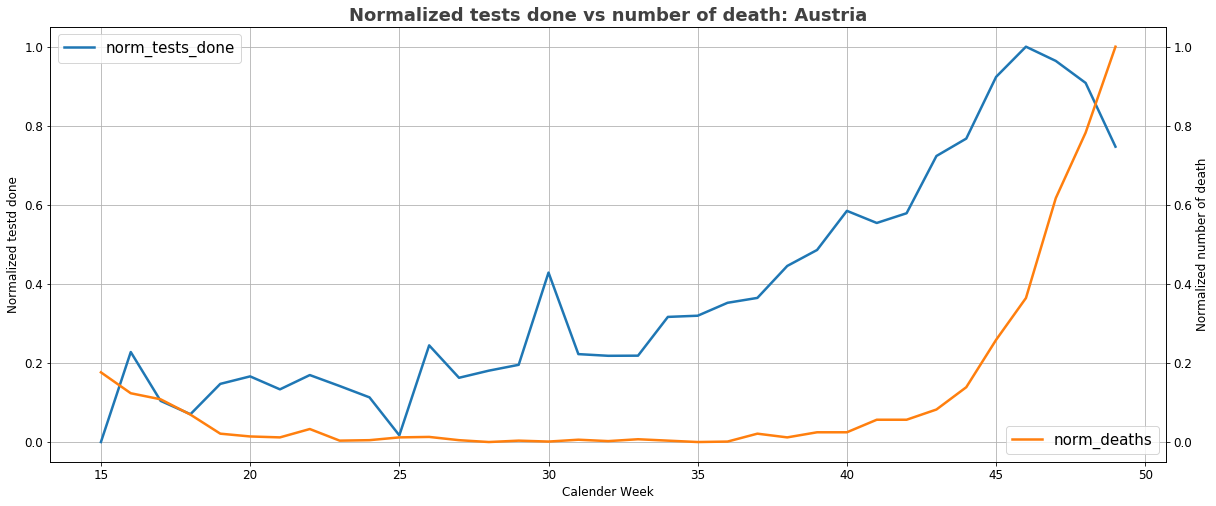

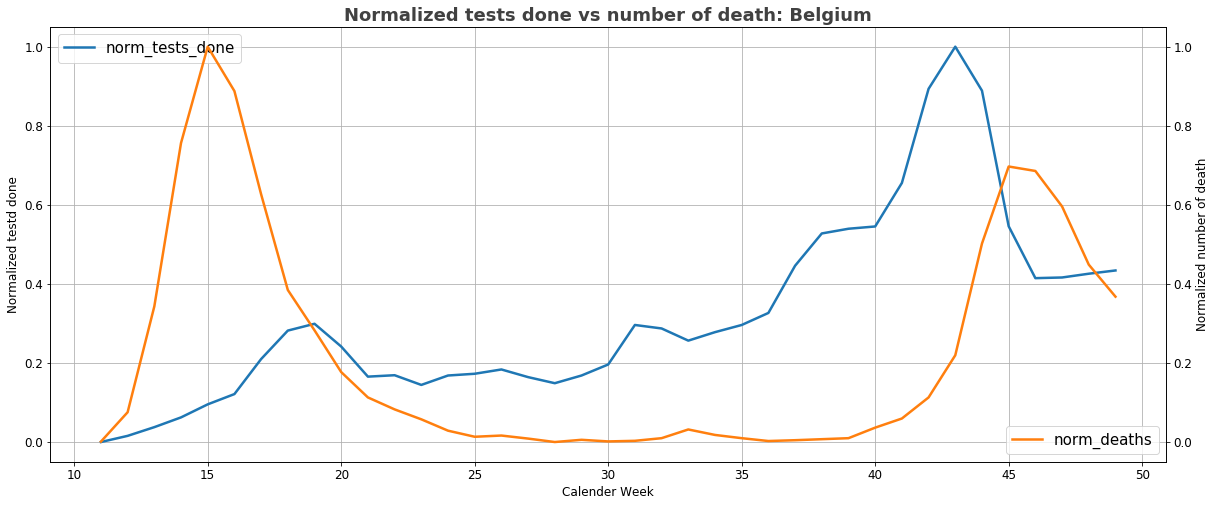

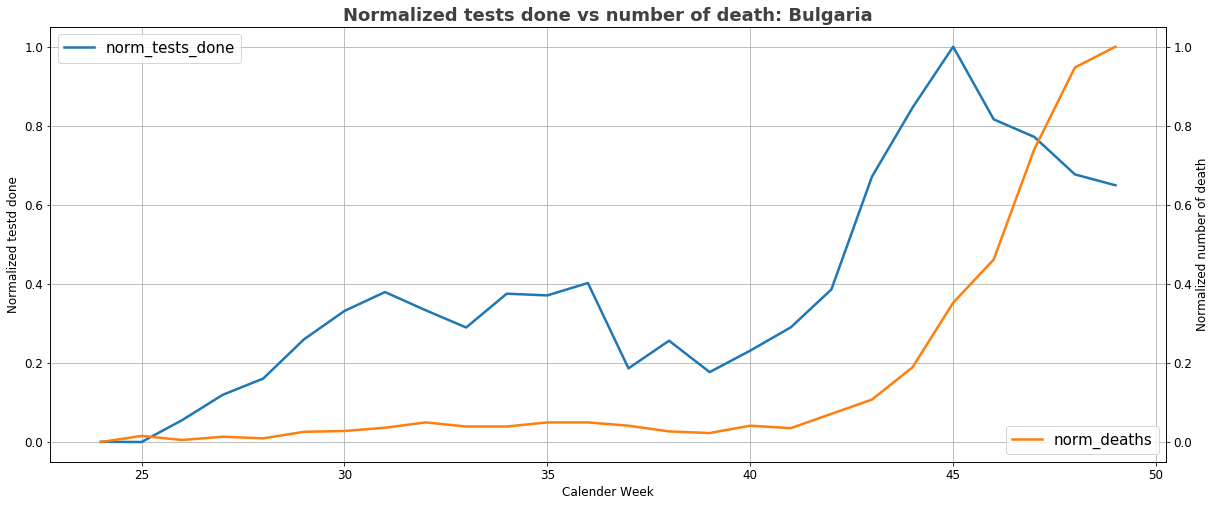

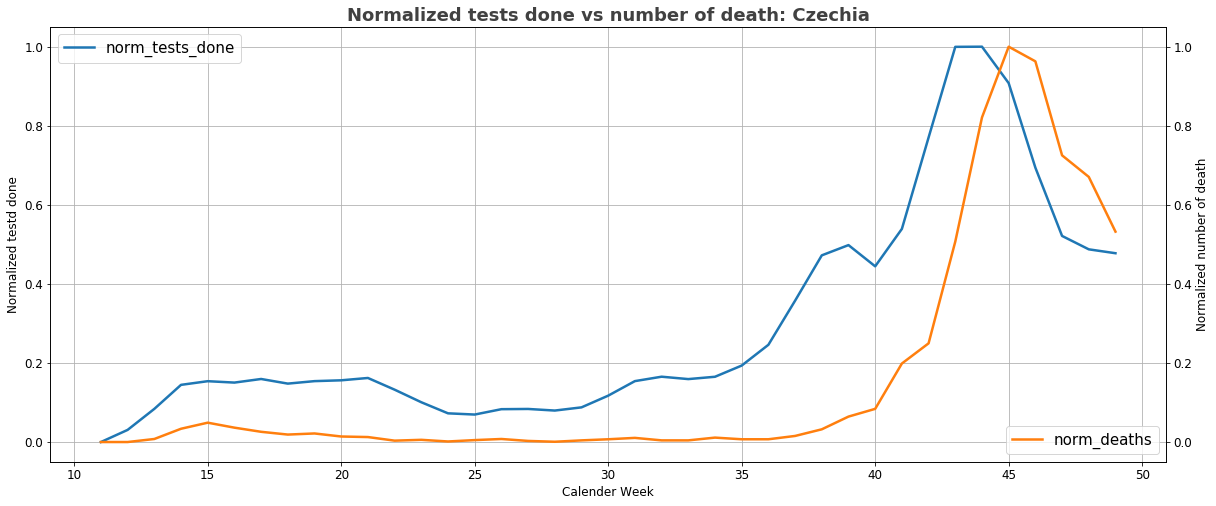

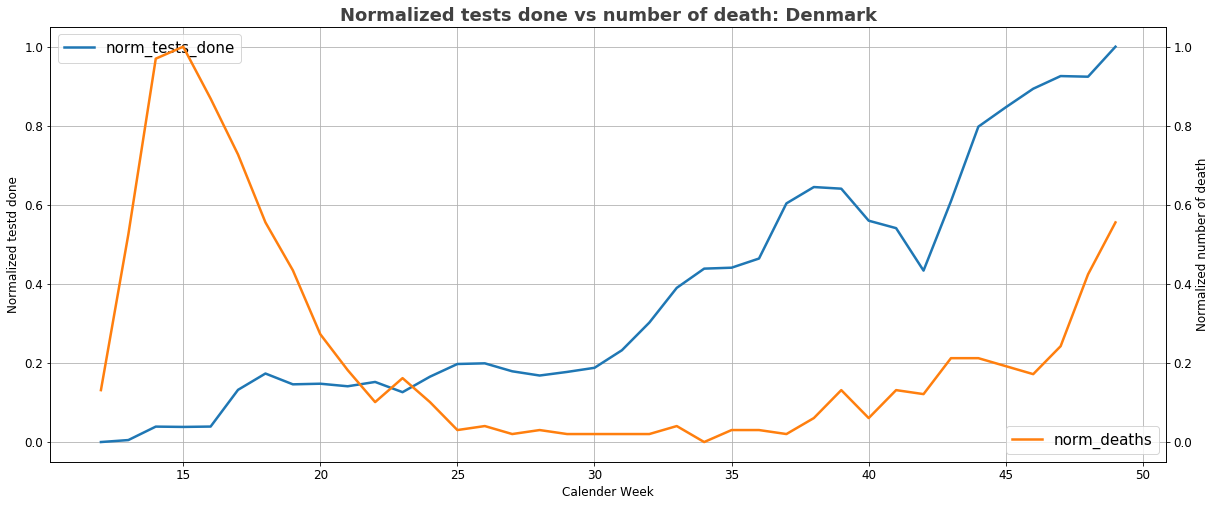

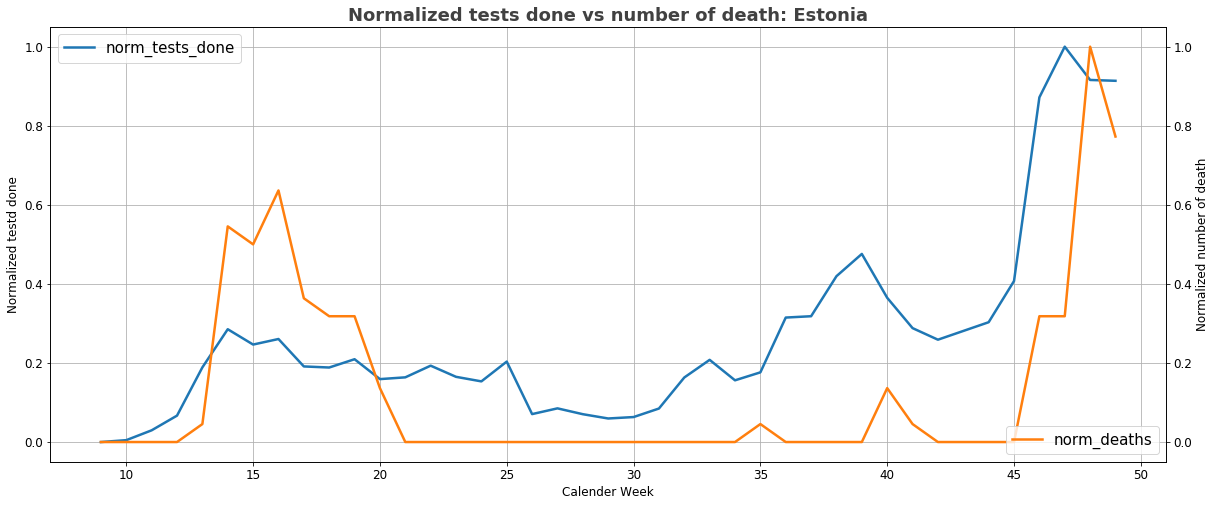

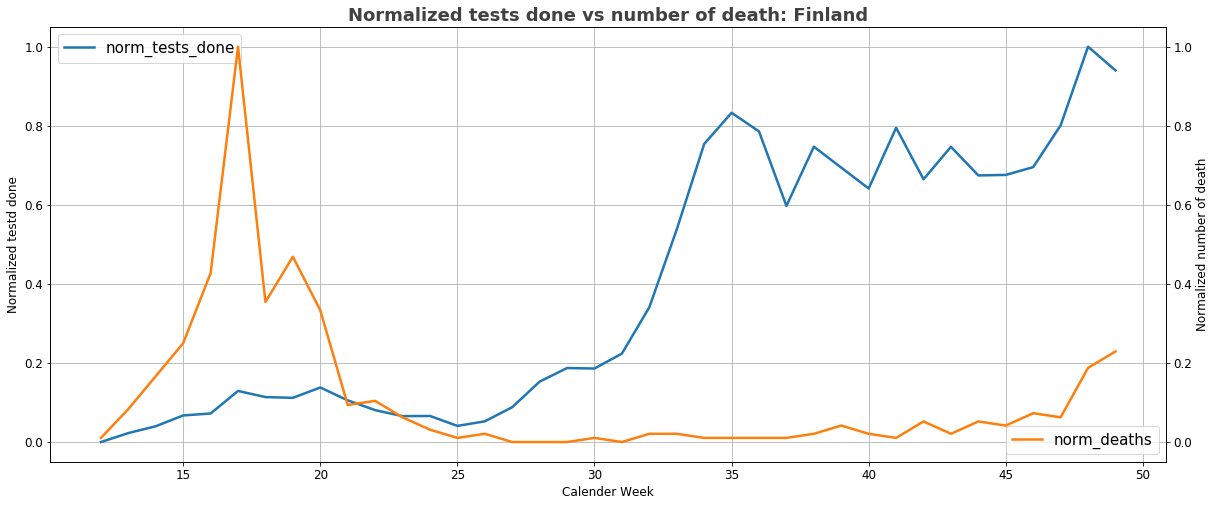

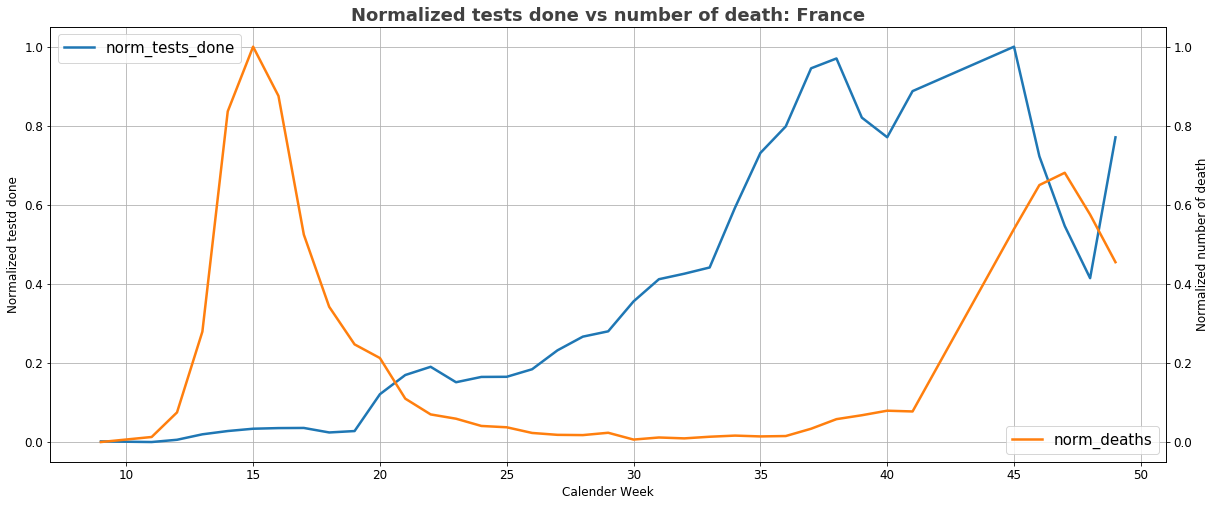

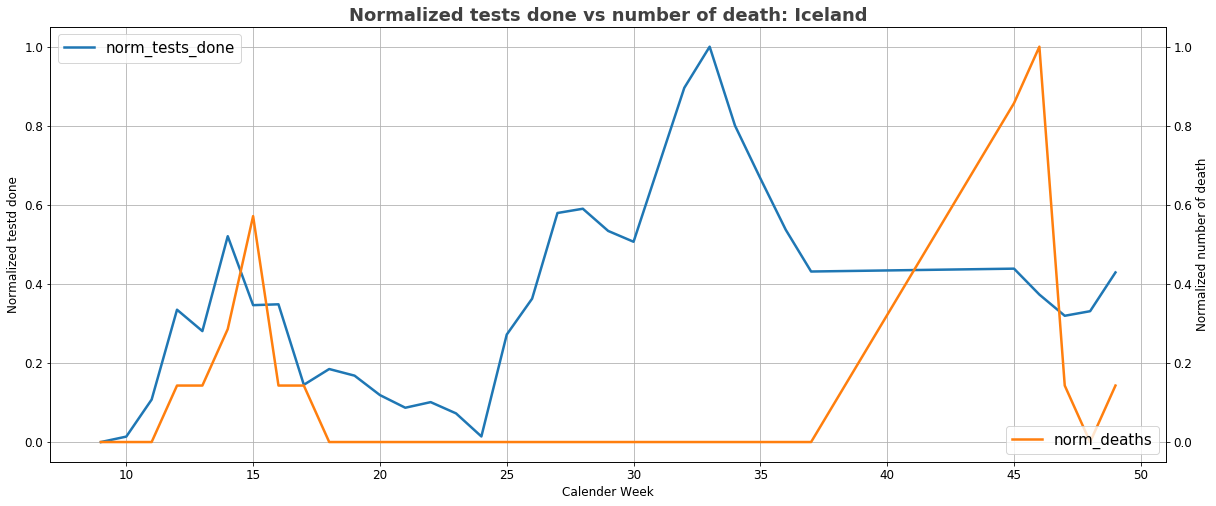

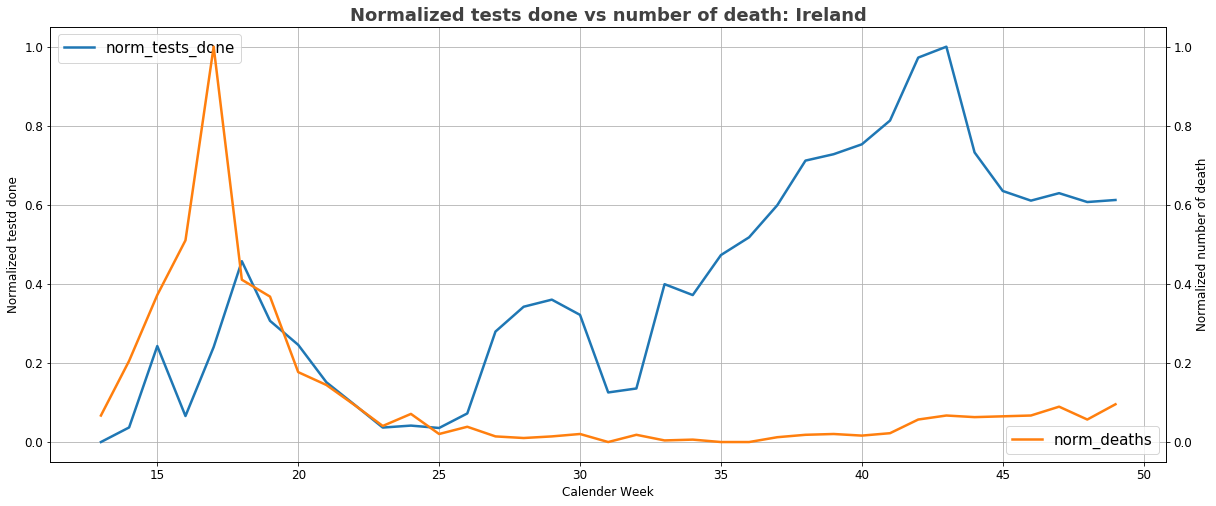

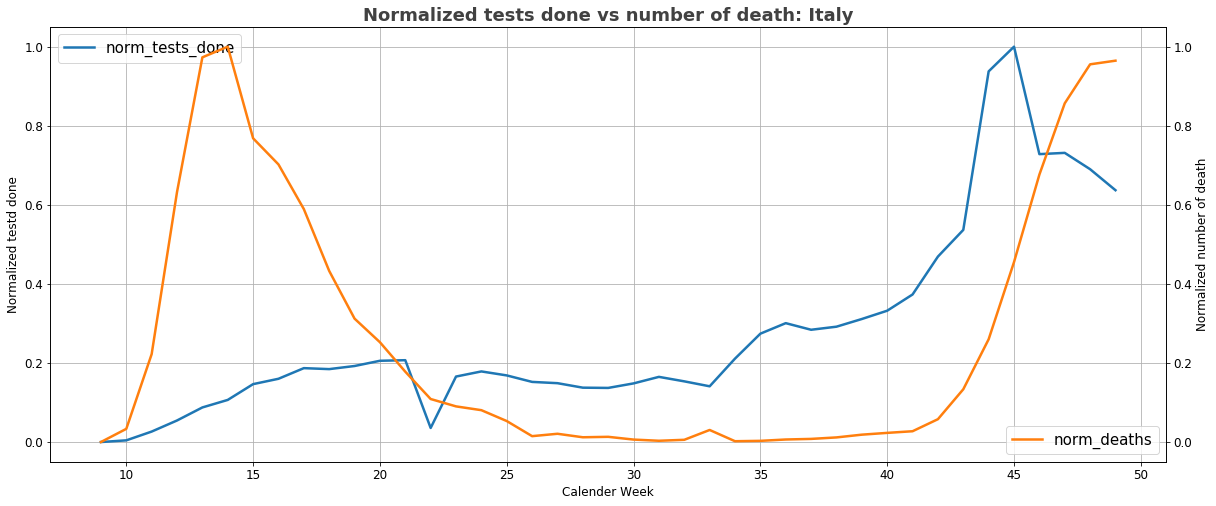

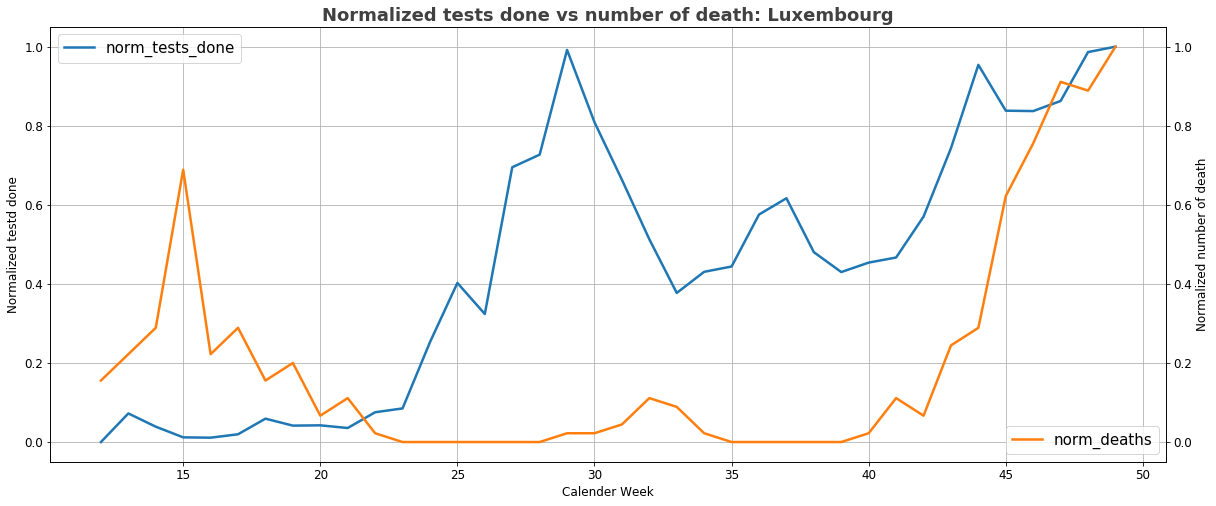

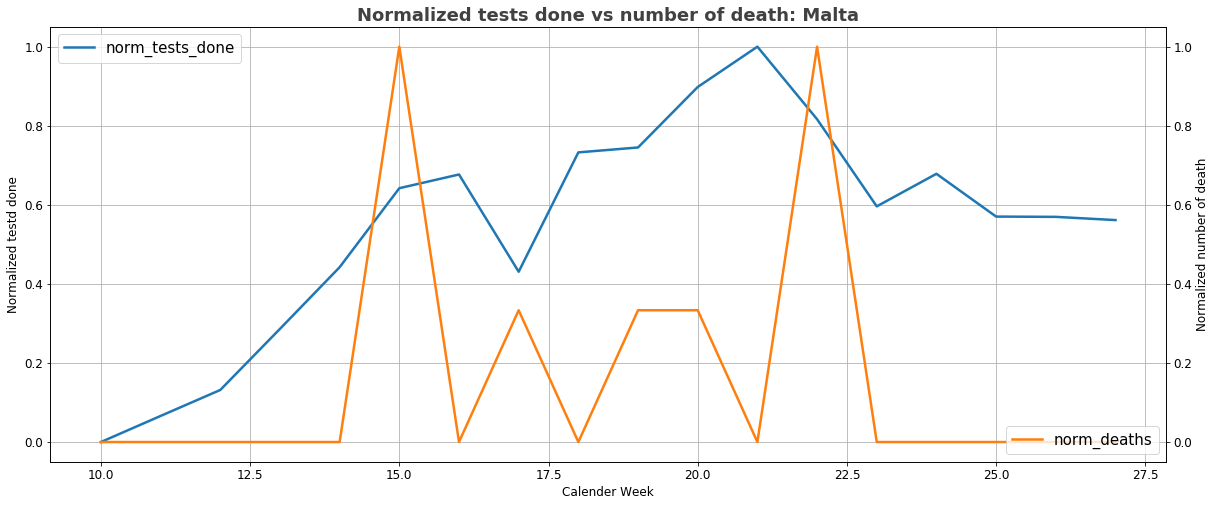

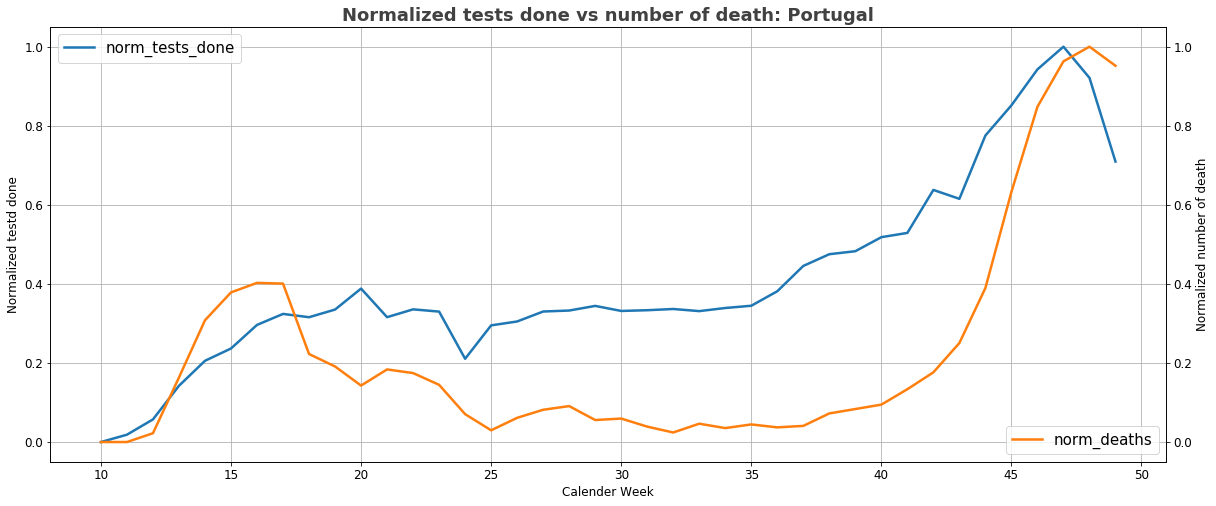

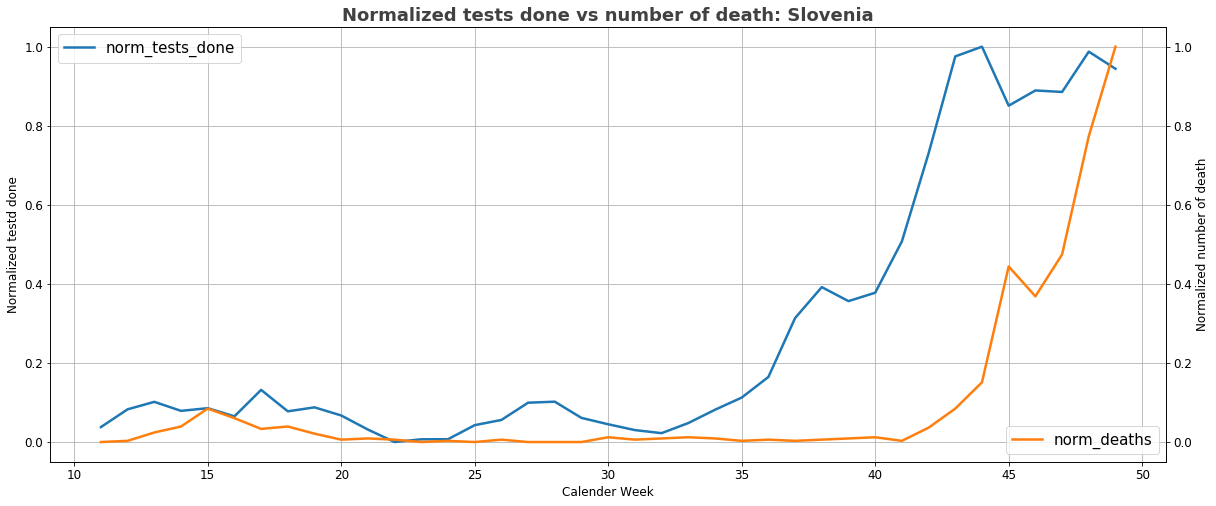

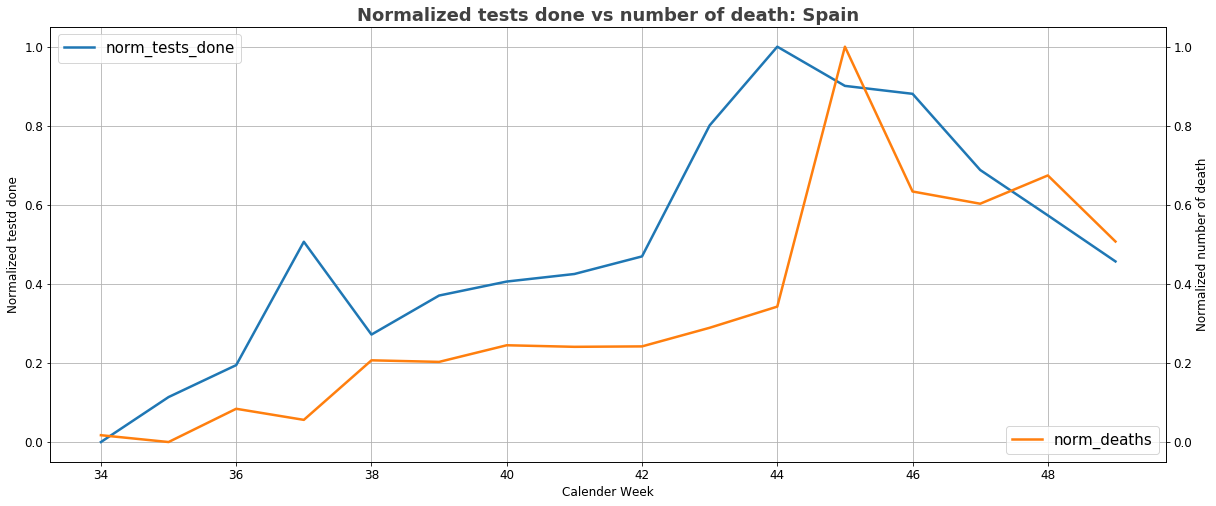

In [478]:
#Plotting norm_test_done vs deaths:
for i,v in enumerate(df.country.unique()):
    fig, ax1 = plt.subplots(figsize=(20,8)) 
    ax1.set_title('Normalized tests done vs number of death:'+ ' '+v,
    fontsize=18, 
    fontweight='semibold', color='#414141') 

    ax1.set_xlabel('report_week')
    ax1 = df[df.country == v].plot(x = 'cw', y = ['norm_tests_done'],linewidth = 2.5, ax = ax1)
    ax2 = df[df.country == v].plot(x = 'cw', y = ['norm_deaths'],linewidth = 2.5, secondary_y = True, ax = ax1)
    ax1.grid(True)
    ax1.xaxis_labels = df[df.country == v].index
    ax2.xaxis_labels = df[df.country == v].index

    ax1.set_xlabel('Week')
    ax1.set_ylabel('Normalized tests done')
    ax1.set_xlabel("Calender Week", fontsize = 12)
    ax1.set_ylabel("Normalized testd done", fontsize = 12)
    ax2.set_ylabel('Normalized number of death', fontsize = 12)

    ax1.tick_params(axis = 'both', which = 'major', labelsize = 12)
    ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)
    ax2.tick_params(axis = 'both', which = 'major', labelsize = 12)
    ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

    ax2.grid(False)
    ax1.grid(True)

    ax1.legend(loc = 2,fontsize = 15)
    ax2.legend(loc = 4,fontsize = 15)
    plt.show()

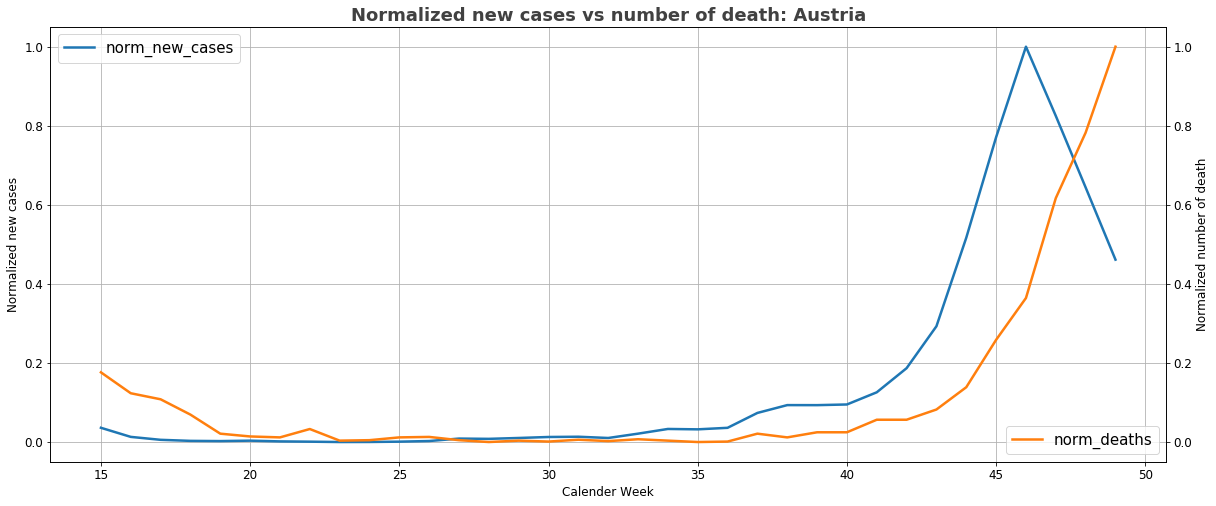

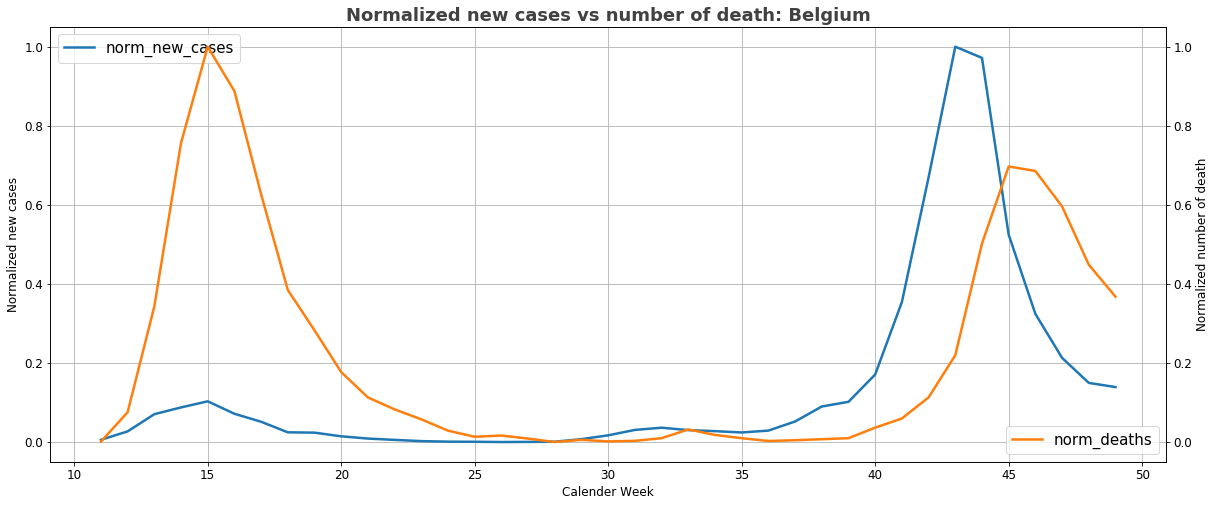

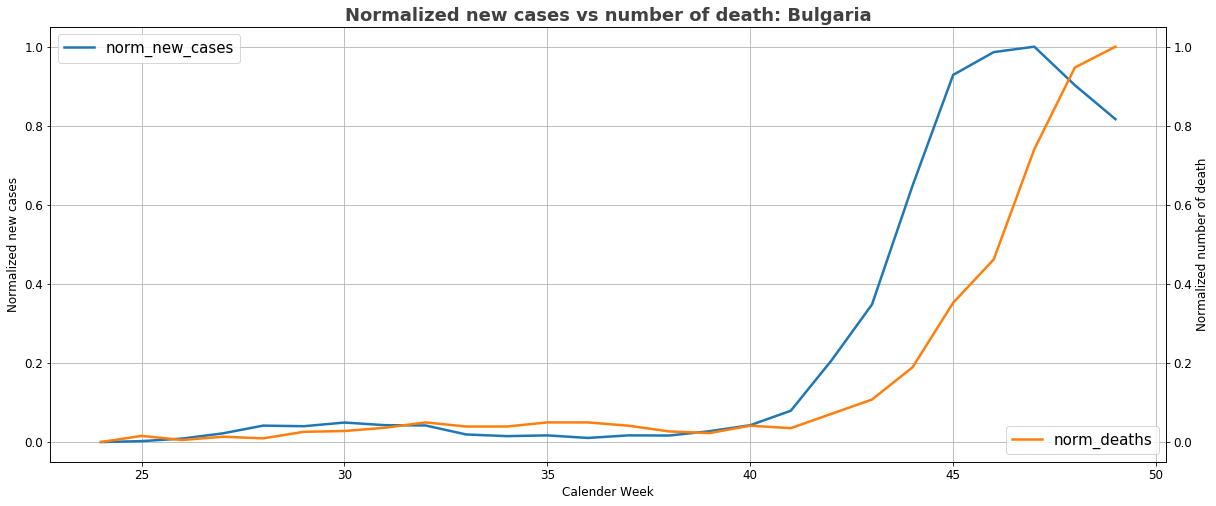

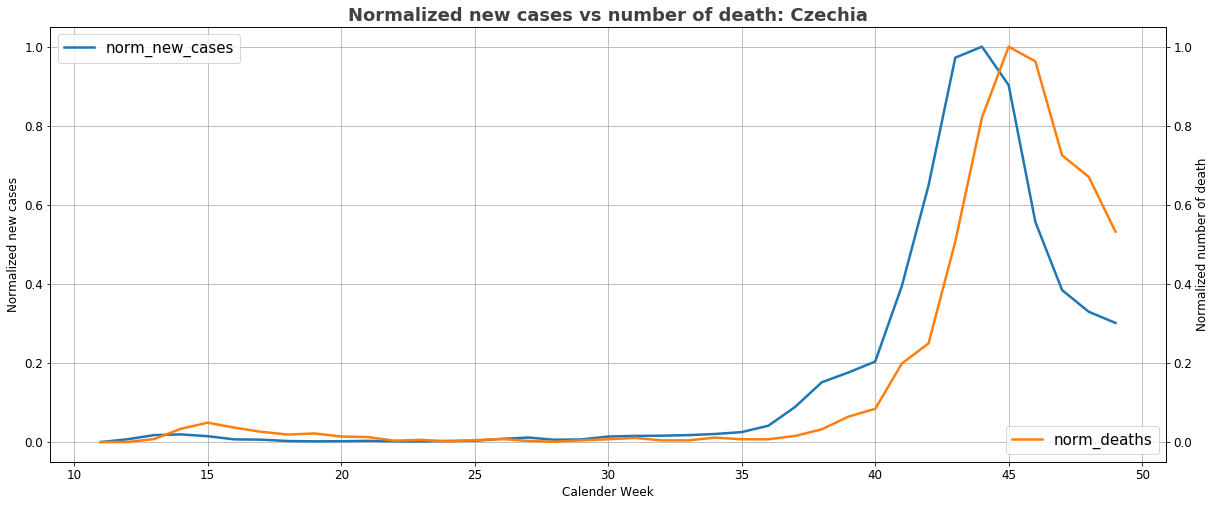

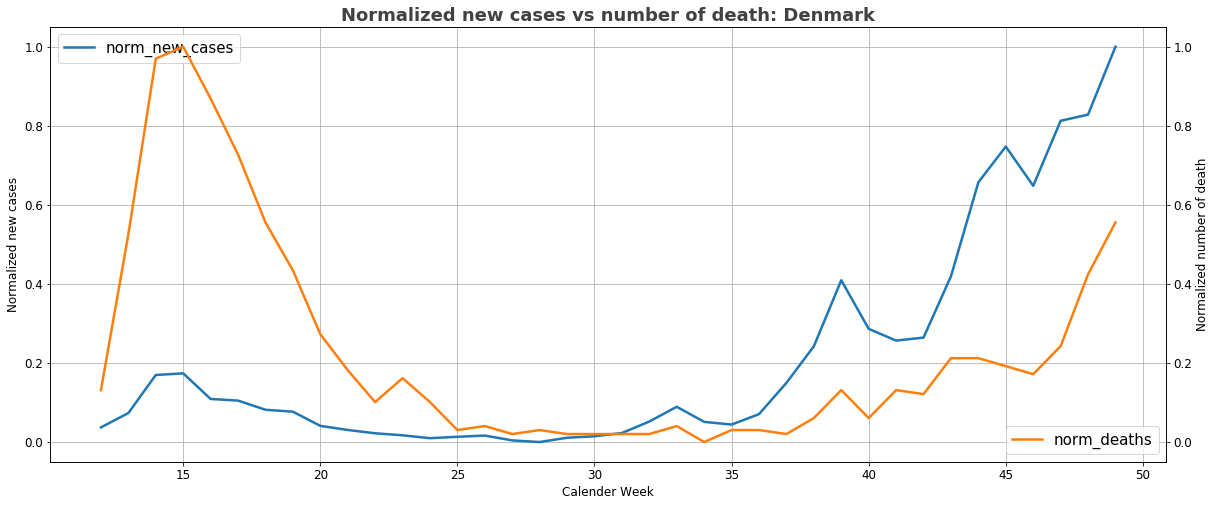

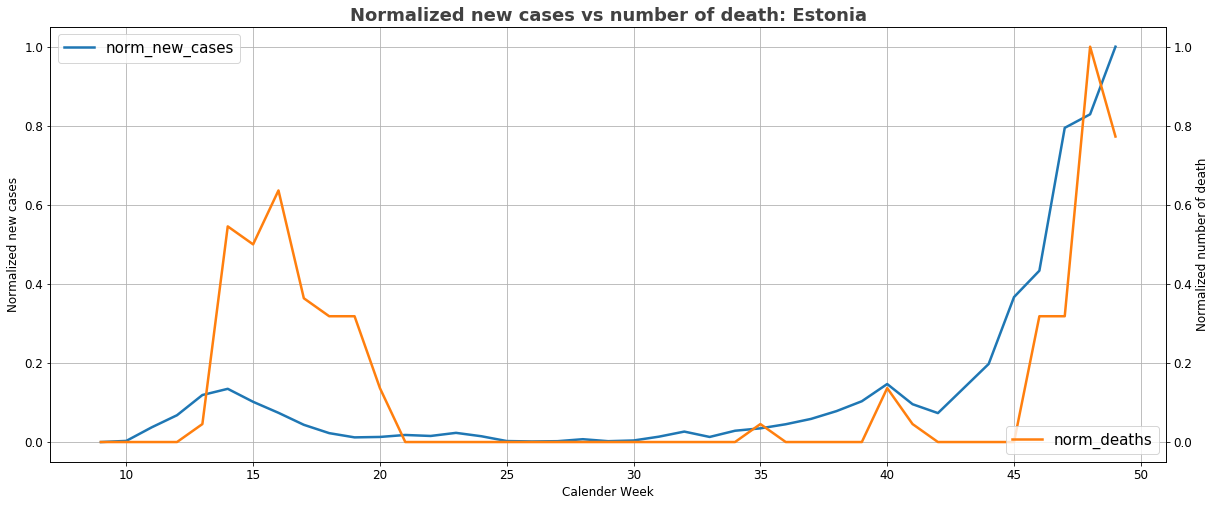

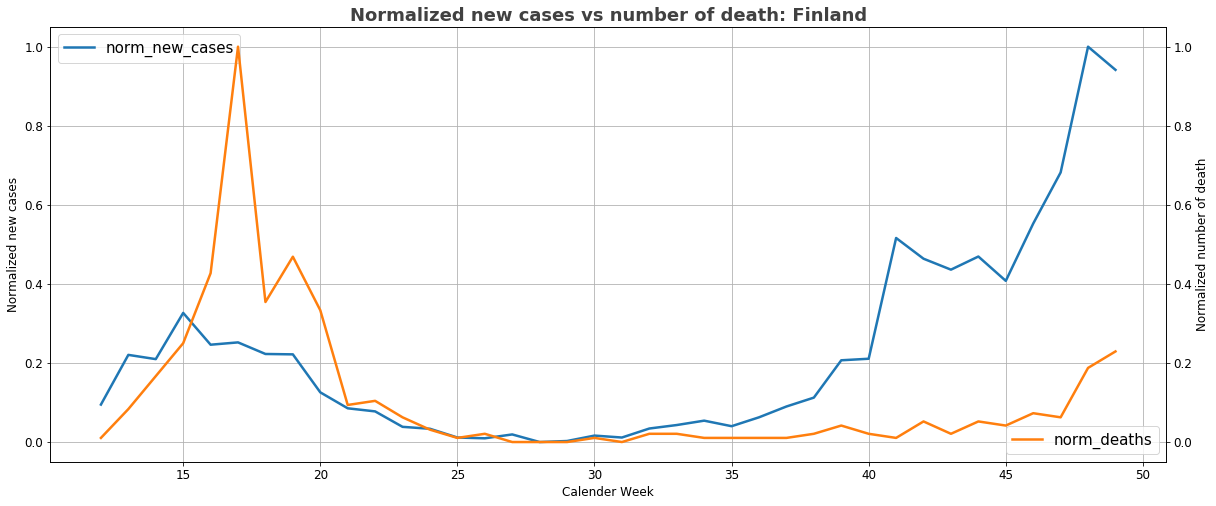

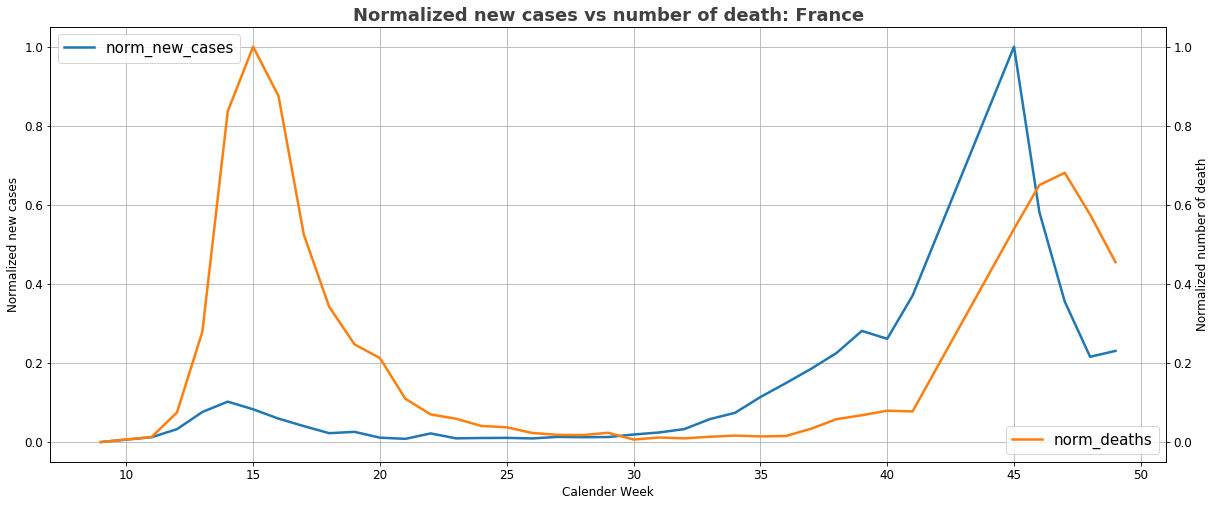

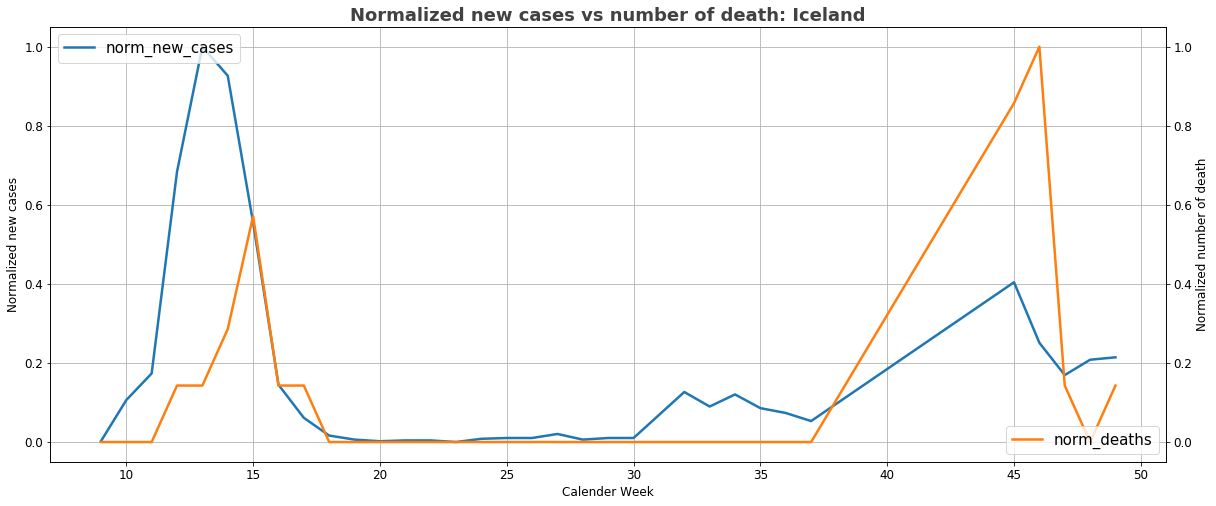

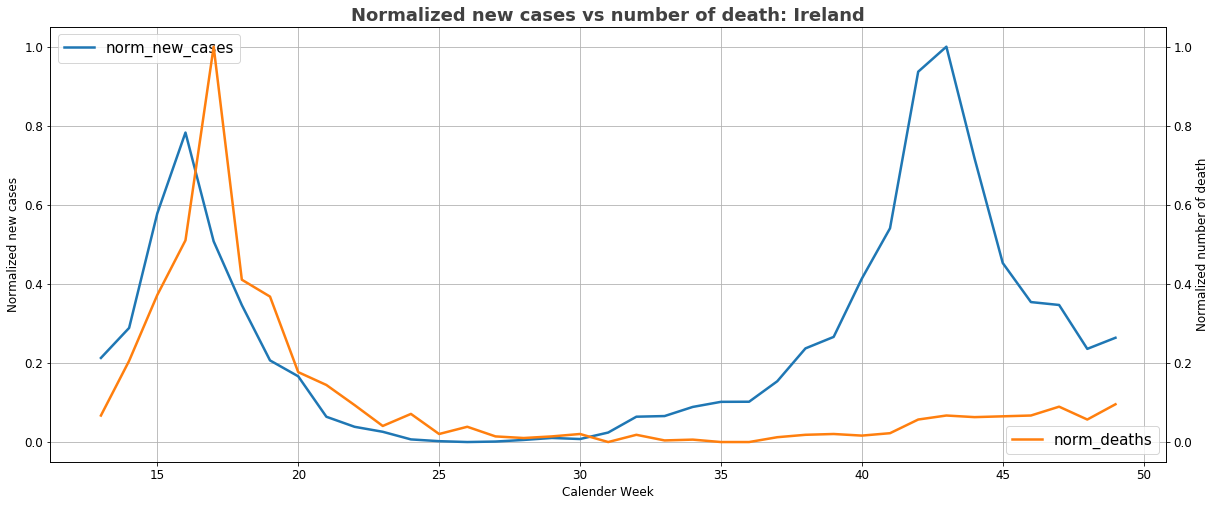

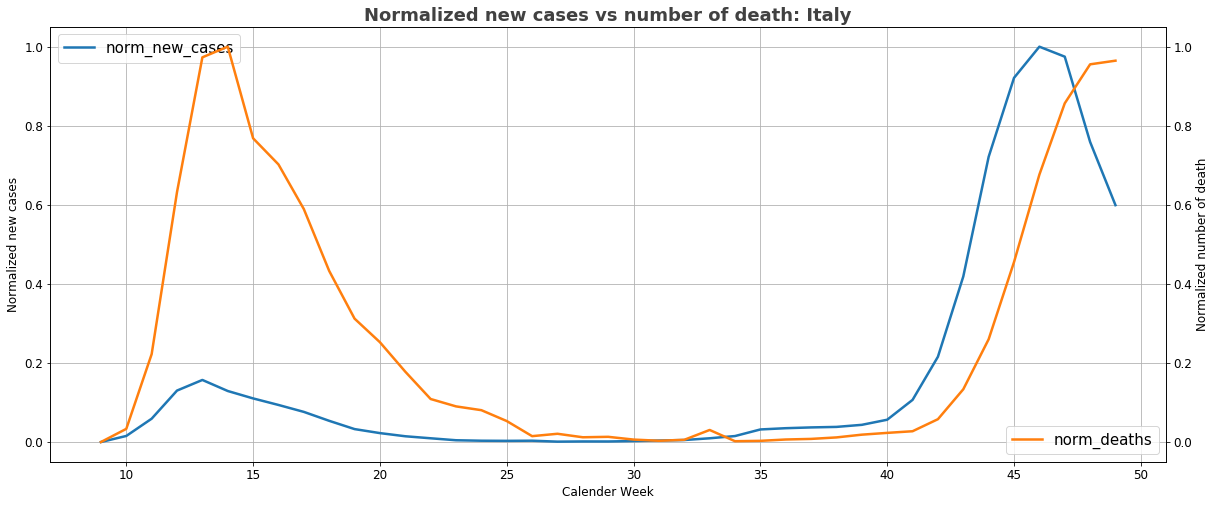

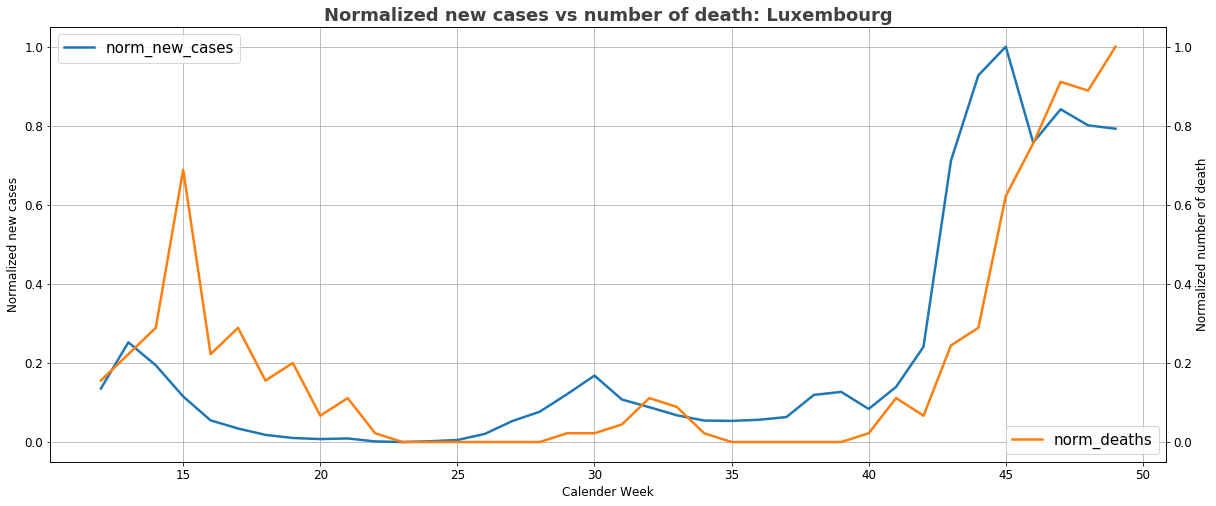

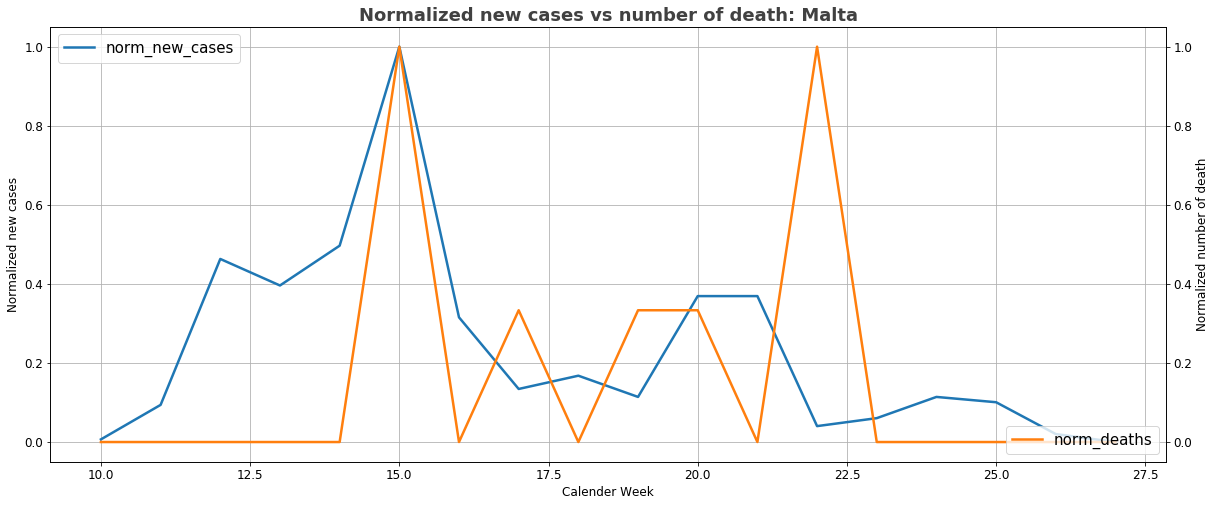

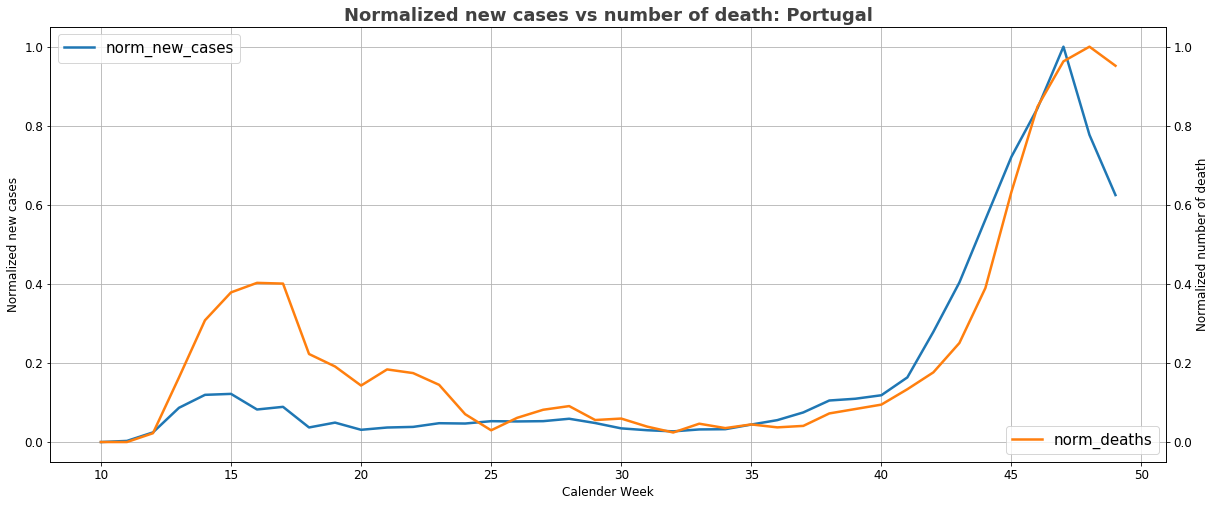

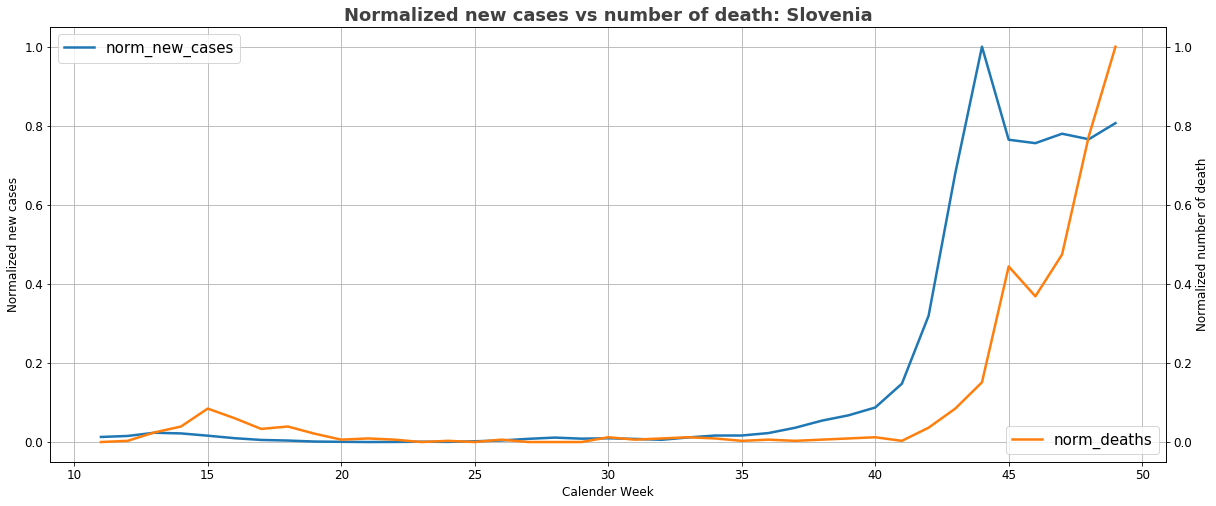

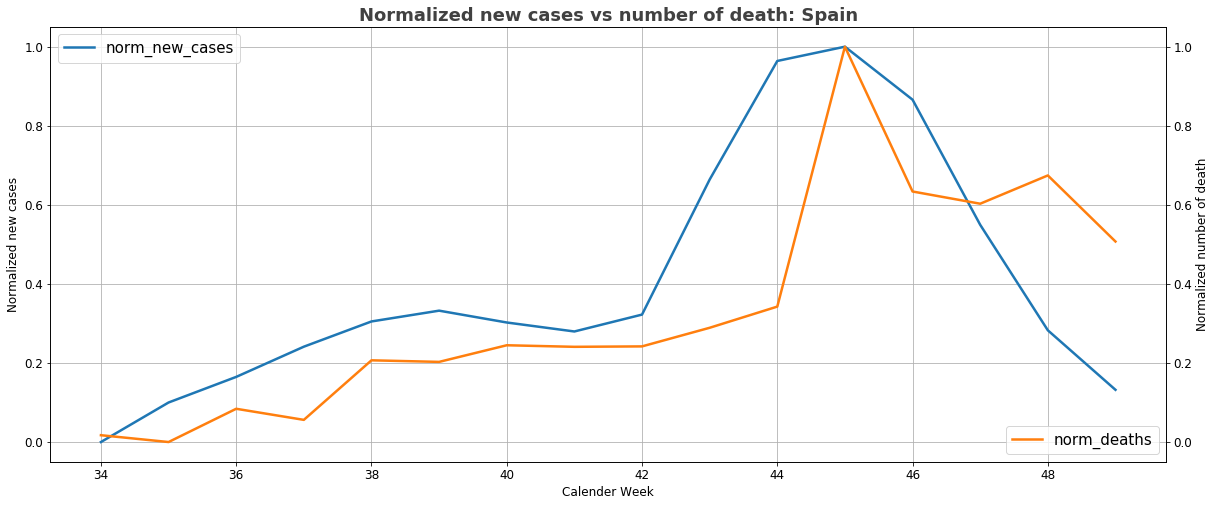

In [479]:
#Plotting norm_new_cases vs deaths:
for i,v in enumerate(df.country.unique()):
    fig, ax1 = plt.subplots(figsize=(20,8)) 
    ax1.set_title('Normalized new cases vs number of death:'+ ' '+v,
    fontsize=18, 
    fontweight='semibold', color='#414141') 

    ax1.set_xlabel('report_week')
    ax1 = df[df.country == v].plot(x = 'cw', y = ['norm_new_cases'],linewidth = 2.5, ax = ax1)
    ax2 = df[df.country == v].plot(x = 'cw', y = ['norm_deaths'],linewidth = 2.5, secondary_y = True, ax = ax1)
    ax1.grid(True)
    ax1.xaxis_labels = df[df.country == v].index
    ax2.xaxis_labels = df[df.country == v].index

    ax1.set_xlabel('Week')
    ax1.set_ylabel('Normalized new cases')
    ax1.set_xlabel("Calender Week", fontsize = 12)
    ax1.set_ylabel("Normalized new cases", fontsize = 12)
    ax2.set_ylabel('Normalized number of death', fontsize = 12)

    ax1.tick_params(axis = 'both', which = 'major', labelsize = 12)
    ax1.tick_params(axis = 'both', which = 'minor', labelsize = 10)
    ax2.tick_params(axis = 'both', which = 'major', labelsize = 12)
    ax2.tick_params(axis = 'both', which = 'minor', labelsize = 10)

    ax2.grid(False)
    ax1.grid(True)

    ax1.legend(loc = 2,fontsize = 15)
    ax2.legend(loc = 4,fontsize = 15)
    plt.show()

### Correlations

In [109]:
for i,v in enumerate(df.country.unique()):
    
    corr = df[(df.country == v)][['norm_tests_done', 'norm_new_cases',
                                       'norm_hosp_occupancy', 'norm_icu_occupancy',
                                       'norm_deaths']].corr()
    print(v)
    corr = round(corr,2)
    print(corr) 

Austria
                     norm_tests_done  norm_new_cases  norm_hosp_occupancy  \
norm_tests_done                 1.00            0.90                 0.75   
norm_new_cases                  0.90            1.00                 0.87   
norm_hosp_occupancy             0.75            0.87                 1.00   
norm_icu_occupancy              0.80            0.92                 0.99   
norm_deaths                     0.64            0.72                 0.94   

                     norm_icu_occupancy  norm_deaths  
norm_tests_done                    0.80         0.64  
norm_new_cases                     0.92         0.72  
norm_hosp_occupancy                0.99         0.94  
norm_icu_occupancy                 1.00         0.93  
norm_deaths                        0.93         1.00  
Belgium
                     norm_tests_done  norm_new_cases  norm_hosp_occupancy  \
norm_tests_done                 1.00            0.85                 0.16   
norm_new_cases                  0.85 

In [111]:
#Just using Spain
corr = df[(df.country == 'Spain')][['norm_tests_done', 'norm_new_cases',
                                       'norm_hosp_occupancy', 'norm_icu_occupancy',
                                       'norm_deaths']].corr()

corr = round(corr,2)
corr

norm_tests_done  norm_new_cases  norm_hosp_occupancy  \
norm_tests_done                 1.00            0.92                 0.82   
norm_new_cases                  0.92            1.00                 0.68   
norm_hosp_occupancy             0.82            0.68                 1.00   
norm_icu_occupancy              0.90            0.83                 0.97   
norm_deaths                     0.71            0.67                 0.91   

                     norm_icu_occupancy  norm_deaths  
norm_tests_done                    0.90         0.71  
norm_new_cases                     0.83         0.67  
norm_hosp_occupancy                0.97         0.91  
norm_icu_occupancy                 1.00         0.90  
norm_deaths                        0.90         1.00

### Predicting number of deaths

#### Linear Regression

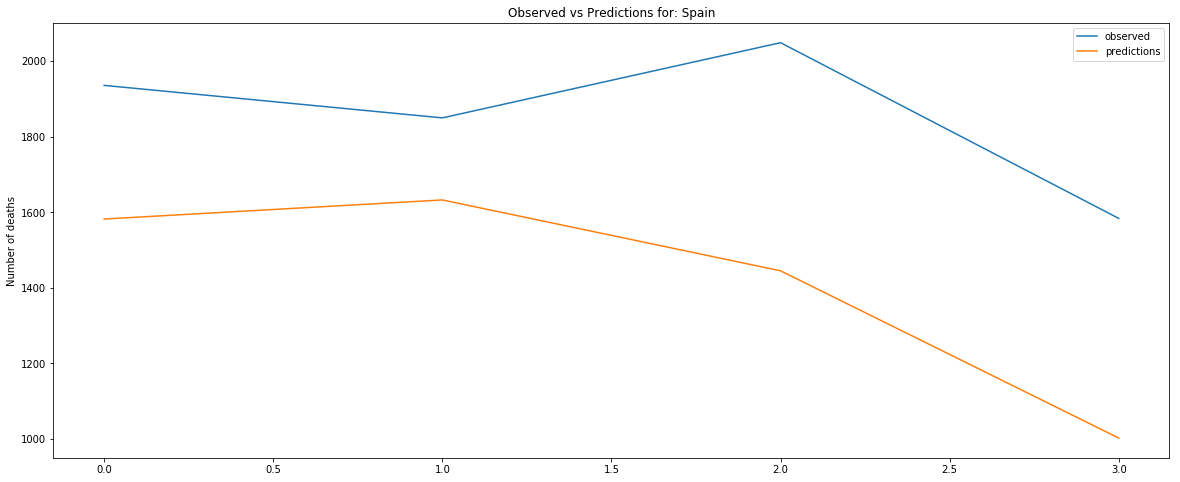

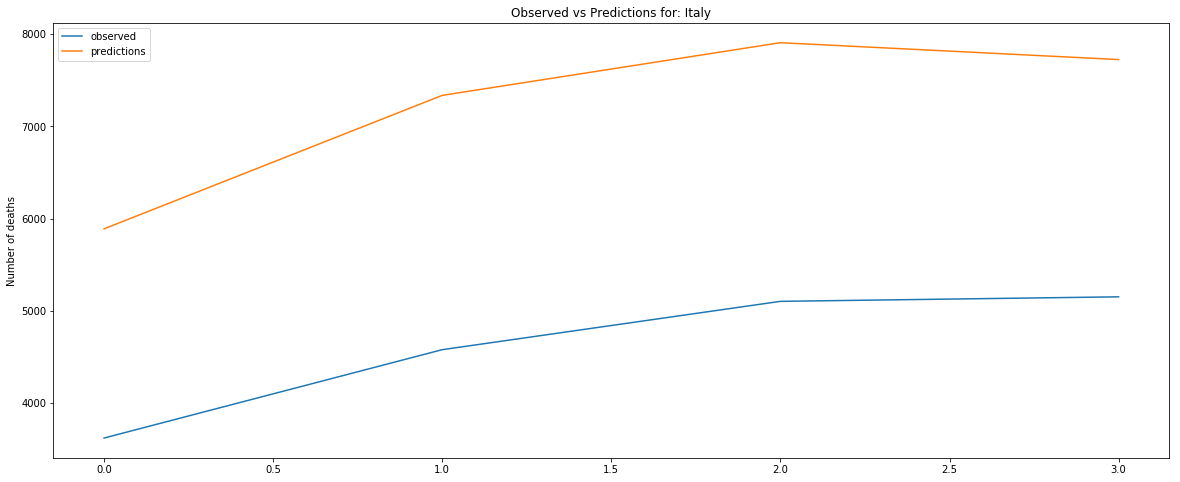

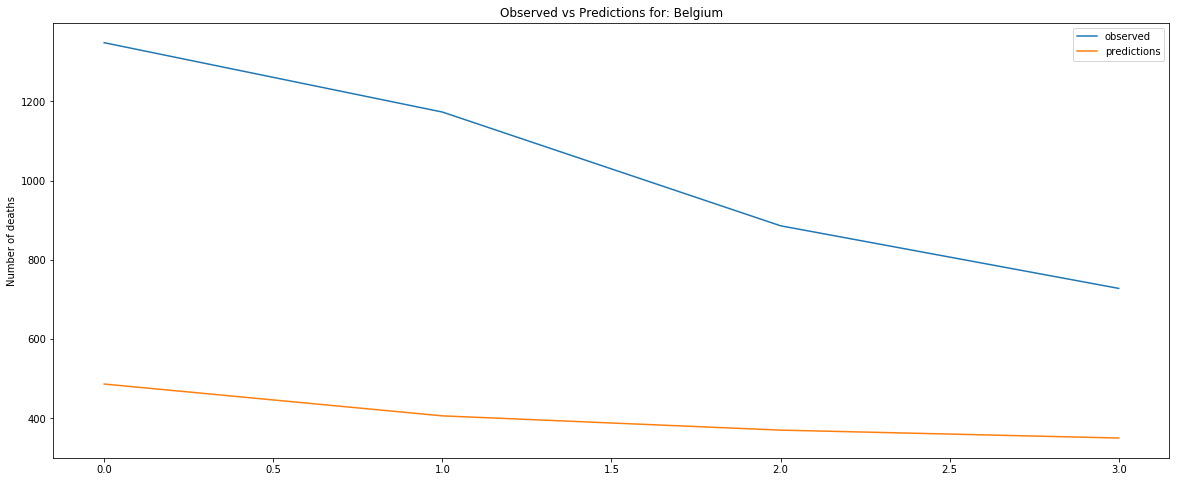

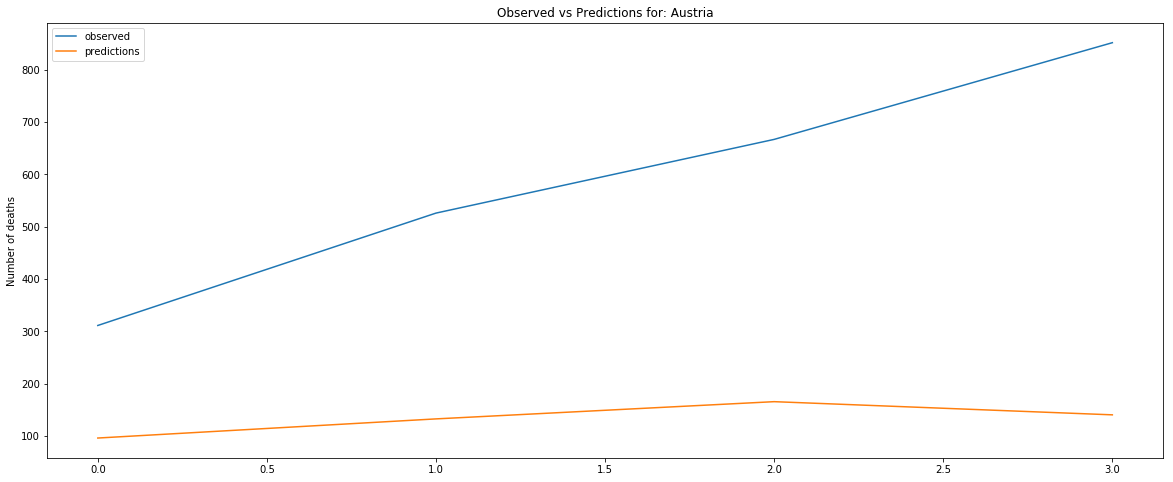

In [671]:
country_list = ['Spain', 'Italy', 'Belgium', 'Austria']

for i,v in enumerate(country_list):
    #Define train and test period/data 
    test_period = 6

    X_train = df[df.country == v].new_cases[:-test_period]
    y_train = df[df.country == v].deaths[:-test_period]

    X_test = df[df.country == v].new_cases[-test_period:]
    y_test = df[df.country == v].deaths[-test_period:]
    
    #Train linear regression
    lr = LinearRegression().fit(np.array(X_train).reshape(-1, 1), y_train)
    
    #Get predictions with 2 weeks delay:
    pred_weeks = [46, 47, 48, 49]
    predictions = []

    for p,q in enumerate(pred_weeks):
        #use new cases from two weeks ago as input for death prediction
        pred_temp = lr.predict(np.array(df[(df.country == v) & (df.cw == q - 2)].new_cases).reshape(-1,1))
        predictions.append(pred_temp[0])
        
   
    plt.figure(figsize=(20,8))
    plt.plot(df[(df.country == v) & (df.cw >= 46)].deaths.tolist(), label='observed')
    plt.plot(predictions, label = 'predictions')
    plt.legend()
    plt.title('Observed vs Predictions for:'+ ' '+v)
    plt.xlabel('')
    plt.ylabel('Number of deaths')
    plt.show()